<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Removing-motorcycles" data-toc-modified-id="Removing-motorcycles-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Removing motorcycles</a></span></li><li><span><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Utility Functions</a></span></li><li><span><a href="#Green-region" data-toc-modified-id="Green-region-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Green region</a></span></li><li><span><a href="#Red-region" data-toc-modified-id="Red-region-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Red region</a></span></li><li><span><a href="#Yellow-region" data-toc-modified-id="Yellow-region-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Yellow region</a></span><ul class="toc-item"><li><span><a href="#Yellow1-Stopped-Region" data-toc-modified-id="Yellow1-Stopped-Region-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Yellow1 Stopped Region</a></span></li><li><span><a href="#Yellow-2-Stopped-Region" data-toc-modified-id="Yellow-2-Stopped-Region-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Yellow 2 Stopped Region</a></span></li><li><span><a href="#Yellow-Results" data-toc-modified-id="Yellow-Results-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Yellow Results</a></span><ul class="toc-item"><li><span><a href="#Yellow-1" data-toc-modified-id="Yellow-1-6.3.1"><span class="toc-item-num">6.3.1&nbsp;&nbsp;</span>Yellow 1</a></span></li><li><span><a href="#Yellow-2" data-toc-modified-id="Yellow-2-6.3.2"><span class="toc-item-num">6.3.2&nbsp;&nbsp;</span>Yellow 2</a></span></li><li><span><a href="#Spillback-Into-Yellow2" data-toc-modified-id="Spillback-Into-Yellow2-6.3.3"><span class="toc-item-num">6.3.3&nbsp;&nbsp;</span>Spillback Into Yellow2</a></span></li><li><span><a href="#Aggregated-Results" data-toc-modified-id="Aggregated-Results-6.3.4"><span class="toc-item-num">6.3.4&nbsp;&nbsp;</span>Aggregated Results</a></span></li></ul></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Results</a></span></li></ul></div>

In [1]:
import time

In [2]:
start_time = time.time()

In [3]:
import pandas as pd
import numpy as np 
import csv
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.neighbors.kde import KernelDensity
from scipy.signal import argrelextrema

/home/danial/anaconda3/envs/merl/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load data

Our first step is to load the data and clean it up.

In [4]:
data_path = "competition_dataset.csv" # define path to dataset
# fps = 25

The following methods loads the dataset into two pandas dataframe: The first contains aggregate vehicle data, or metadata; the second contains trajectory information.

In [5]:
def read_uas4t_csv(path):
    metadata_cols = ['track_id', 'type', 'traveled_d', 'avg_speed']
    metadata_dtypes = [int, str, float, float]
    data_cols = ['lat', 'lon', 'speed', 'lat_acc', 'lon_acc', 'time', 'track_id']
    
    metadata_colsize = len(metadata_cols)
    data_colsize = len(data_cols)-1
    
    metadata_rows = list()
    data_rows = list()
    
    with open(data_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        next(csv_reader)
        metadata = dict()
        for row in csv_reader:
            row = [item.strip() for item in row]
            track_id = int(row[0])
            metadata_rows.append(row[:metadata_colsize])

            data_traj = [float(item) for item in row[metadata_colsize:]
                          if len(item) > 0]
            for i in range(0,len(data_traj),data_colsize):
                data_row = data_traj[i:i+data_colsize] + [track_id]
                data_rows.append(data_row)
            
    data = pd.DataFrame(data_rows, columns=data_cols)     
    metadata = pd.DataFrame(metadata_rows, columns=metadata_cols)
    metadata = metadata.set_index('track_id')
    metadata.index = metadata.index.astype(int)
    return metadata, data

In [6]:
metadata, data = read_uas4t_csv(data_path)

Here's what the dataframes look like:

In [7]:
metadata.head()

,type,traveled_d,avg_speed
track_id,,,
1,Car,16.70,15.820474
2,Car,99.46,27.542773
3,Car,96.59,33.433303
4,Car,104.39,27.232685
5,Medium Vehicle,102.86,32.481984


In [8]:
data.head()

,lat,lon,speed,lat_acc,lon_acc,time,track_id
0,37.991016,23.735396,12.4578,-0.0633,0.0169,0.00,1
1,37.991016,23.735397,12.4544,0.0154,0.0193,0.04,1
2,37.991016,23.735399,12.4601,0.0638,0.0215,0.08,1
3,37.991016,23.735400,12.4727,0.1122,0.0238,0.12,1
4,37.991015,23.735402,12.4957,0.2060,0.0259,0.16,1


We can see that the dataframe key is just a sequence of numbers. A more informative key would be better. A trajectory is uniquely labeled by `track_id` and the snapshot in time is uniquely labeled by `time`. The id-time pair therefore uniquely identifies each datapoint. We therefore use these two columns to reindex the dataframe.

We would rather work with integer values for indexing, so we convert `time` to an integer. We note that it appears that the time values increment in steps of 1/25, where we assume 25 is the frame rate.

In [9]:
fps = 25
max(abs(round(fps*data['time'])-fps*data['time']))

1.8189894035458565e-12

In [10]:
data['frame'] = round(fps*data['time']).astype(int)
data.set_index(['track_id','frame'],drop=True,inplace=True)

Here's what the data frame looks like now:

In [11]:
data.head()

lat        lon    speed  lat_acc  lon_acc  time
track_id frame                                                       
1        0      37.991016  23.735396  12.4578  -0.0633   0.0169  0.00
         1      37.991016  23.735397  12.4544   0.0154   0.0193  0.04
         2      37.991016  23.735399  12.4601   0.0638   0.0215  0.08
         3      37.991016  23.735400  12.4727   0.1122   0.0238  0.12
         4      37.991015  23.735402  12.4957   0.2060   0.0259  0.16

The lat-lon values are cumbersome to work with as they have high precision, but their range is small. To reduce scale, we begin by computing the bounding box of the spatial coordinates.

In [12]:
lat0 = data['lat'].min()
lat1 = data['lat'].max()
dlat = lat1-lat0

lon0 = data['lon'].min()
lon1 = data['lon'].max()
dlon = lon1-lon0

Note that, since the Earth is locally flat, we can treat longitude and latitude as locally Euclidean coordinates. We can see from the data that the accuracy of the measurements is to the 6th significant digit:

In [13]:
print([lat0, lon0, lat1, lon1])

[37.989523, 23.730278, 37.99281, 23.736517]


To confirm out flatness hypothesis, we determine the coordinates of the box bounds in a locally flat frame. The formulas for this are found on the Great Circle Calculator at http://edwilliams.org/avform.htm.

In [14]:
a = 6378.137          # equitorial radius from WGS84 model in km
f = 1./298.257223563  # spheroid flattening factor from WGS84 model

e2 = f*(2-f)          # eccentricity squared

sin_lat0 = np.sin(np.deg2rad(lat0))
cos_lat0 = np.cos(np.deg2rad(lat0))
n = np.sqrt(1 - e2*sin_lat0**2)

R1 = (1-e2) * a / n**3
R2 = a / n

dN = R1 * np.deg2rad(dlat)
dE = R2 * cos_lat0 * np.deg2rad(dlon)

We check the diagonal distance obtained using the flatness assumption against the actual, great-circle distance given by the Great Circle Calculator, which is 658.387m.

In [15]:
true_diag = 658.387
flat_diag = 1e3*np.sqrt(dN**2 + dE**2)
print(round(flat_diag-true_diag,3)) # print error to 3 significant digits

0.01


The error given by the flatness approximation is no more than 1cm, and therefore negligible.

We define a new method that transforms lat-lon into one-millionth lat-lon units and use this to define two new `N` and `E` columns in the dataframe.

In [16]:
def convLL(LLcol,scale,LL0):
    return (scale*(LLcol-LL0)).apply(round).astype(int)

scale = 1e6

In [17]:
data['N'] = convLL(data['lat'],scale=scale,LL0=lat0)
data['E'] = convLL(data['lon'],scale=scale,LL0=lon0)

Here's what the dataframe looks like now.

In [18]:
data.head()

lat        lon    speed  lat_acc  lon_acc  time     N  \
track_id frame                                                                
1        0      37.991016  23.735396  12.4578  -0.0633   0.0169  0.00  1493   
         1      37.991016  23.735397  12.4544   0.0154   0.0193  0.04  1493   
         2      37.991016  23.735399  12.4601   0.0638   0.0215  0.08  1493   
         3      37.991016  23.735400  12.4727   0.1122   0.0238  0.12  1493   
         4      37.991015  23.735402  12.4957   0.2060   0.0259  0.16  1492   

                   E  
track_id frame        
1        0      5118  
         1      5119  
         2      5121  
         3      5122  
         4      5124

We will be working with image-based data, so we create a method to convert the data into an image. The first image we create will be a black and white image of all traffic trajectories at the highest resolution. The image shows all traffic over the entire monitoring period. Each pixel's intensity is proportional to the number of times a vehicle's position occupied that point, with white representing the highest intensity. We saturate the intensity according to the parameter `sat_count` which we set at a default of $10$.

In [19]:
Nrange = data['N'].max()+1
Erange = data['E'].max()+1

In [20]:
def create_traffic_heatmap(pos,sat_count=10,min_count=1):    
    img_array = np.zeros((Nrange,Erange))     # initalize image array
    
    uniques = pos.value_counts()                      # find unique values and apply to array
    img_array[tuple(np.asarray(tuple(uniques.index)).T)] = uniques.values
    img_array[img_array < min_count] = 0
        
    img_array = np.clip(img_array,0,sat_count) / sat_count        # scale and saturate
    
    im = Image.fromarray(np.uint8(np.flipud(img_array)*255),'L')  # create image from array
    
    return im, img_array

In [21]:
im_baseline, im_baseline_array = create_traffic_heatmap(data[['N','E']],sat_count=3,min_count=2)

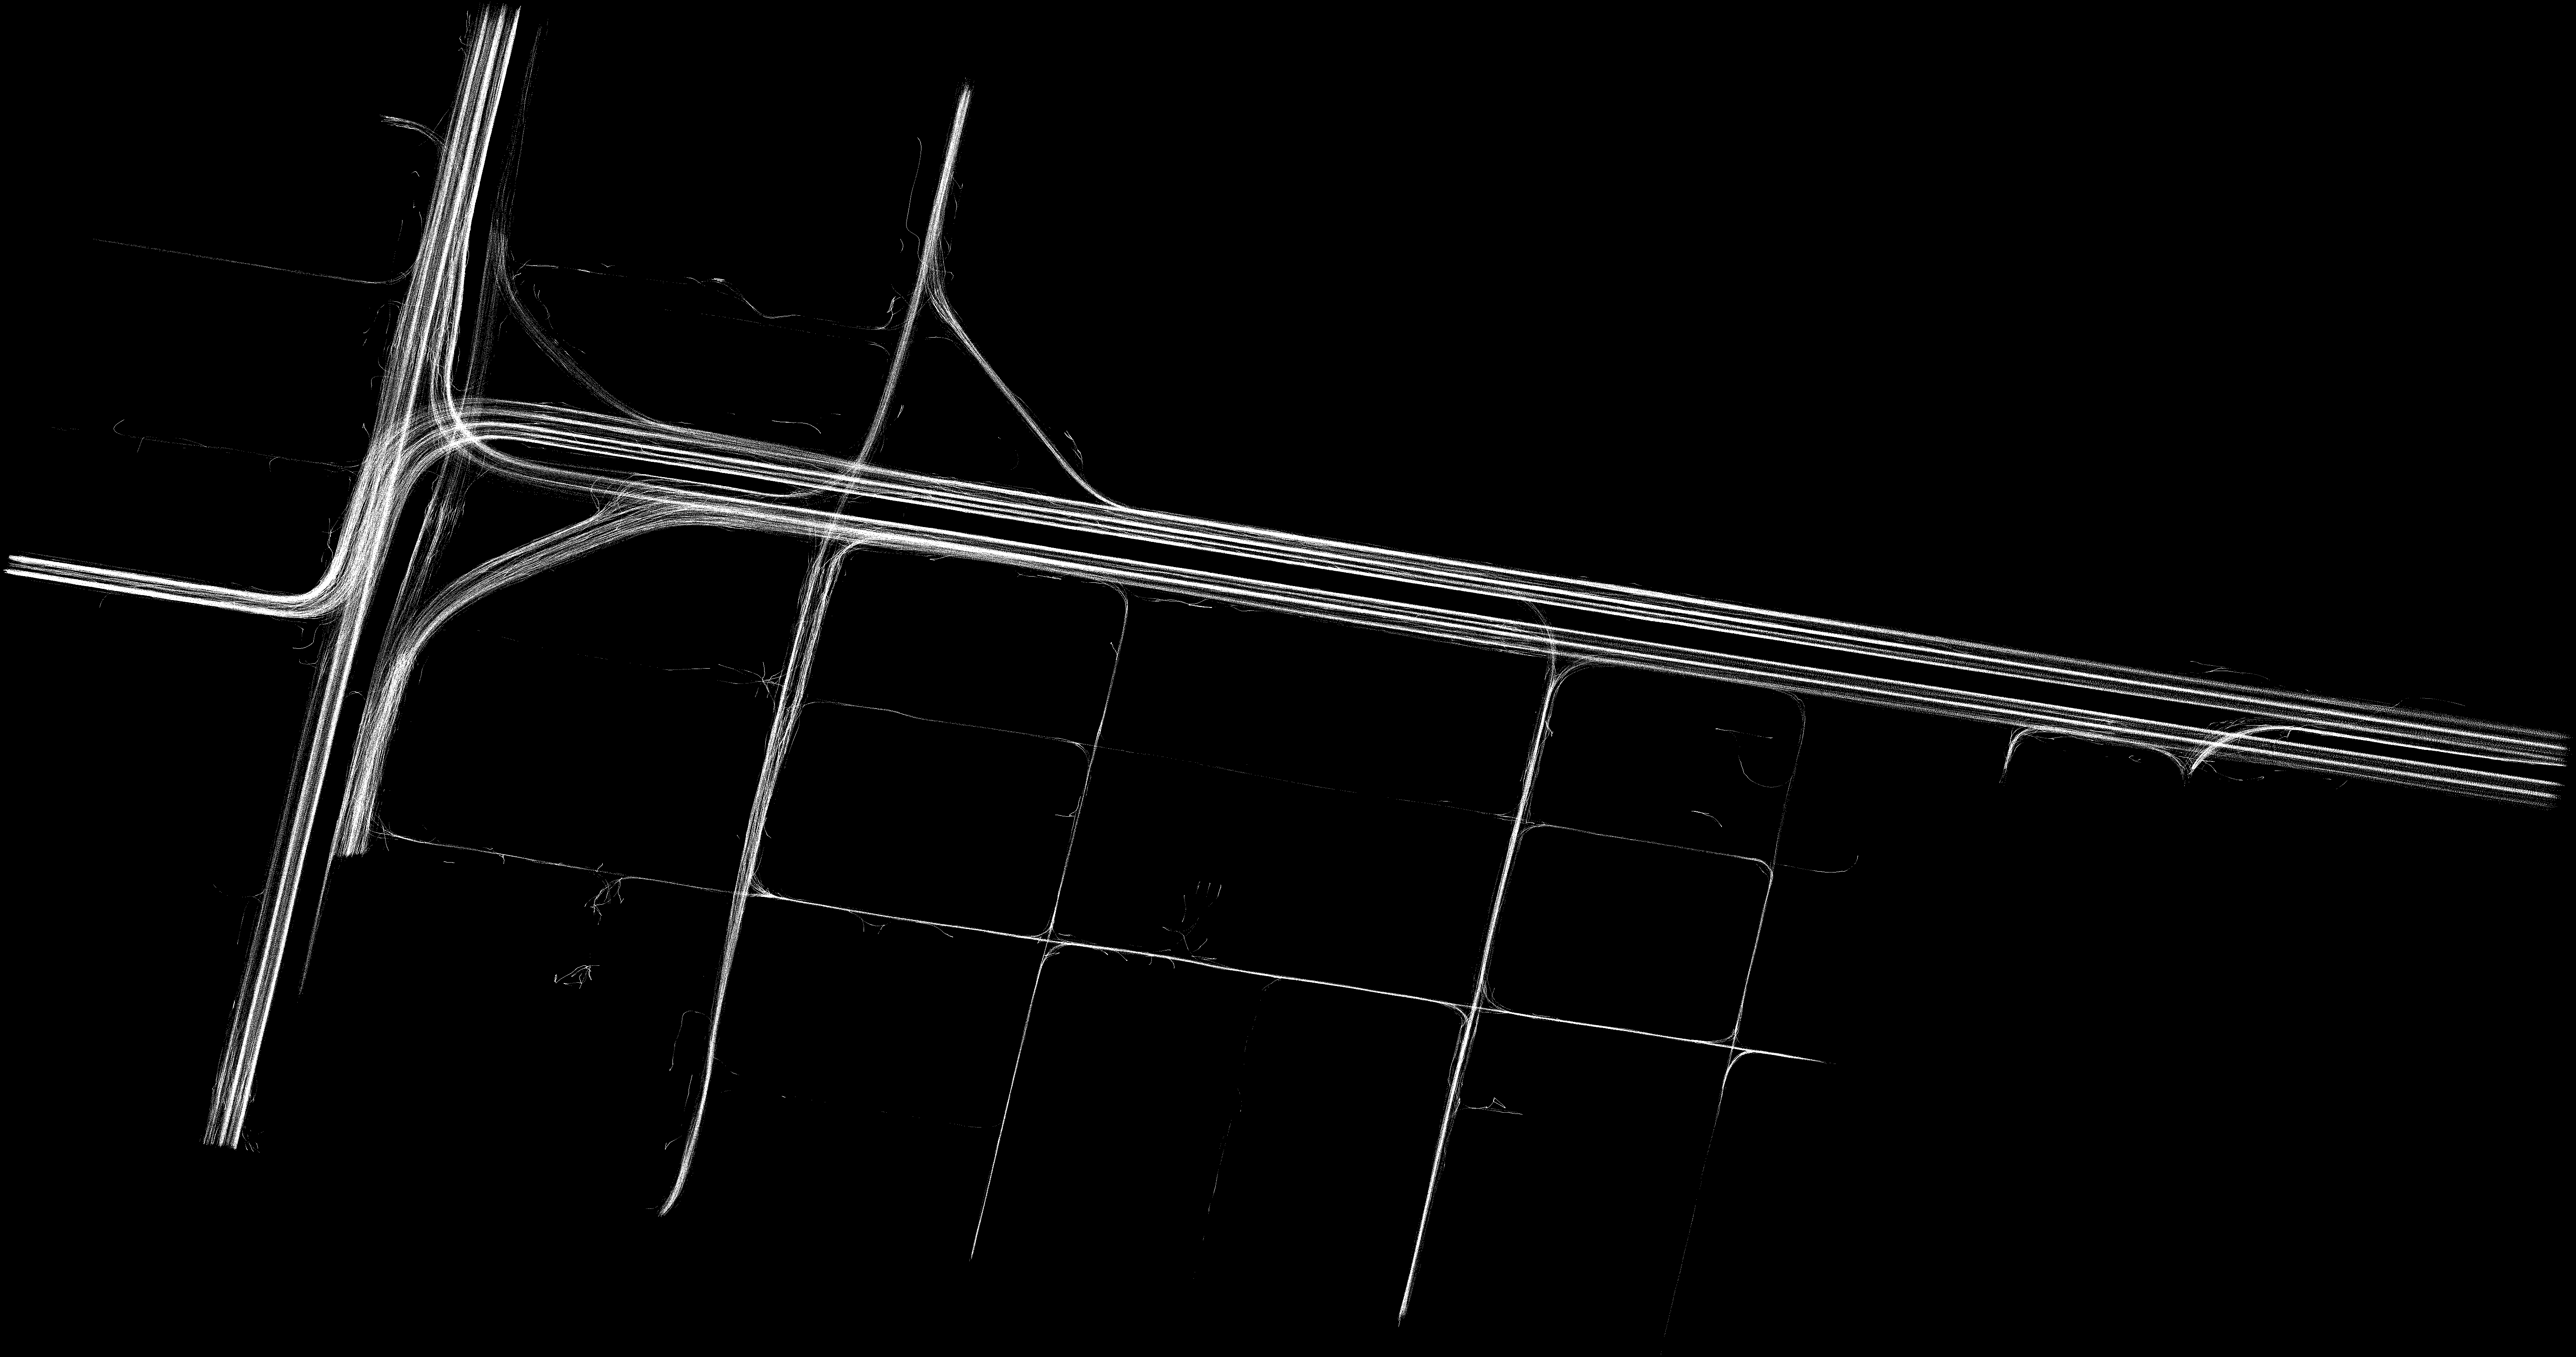

In [22]:
display(im_baseline)

The image clearly shows the trajectories of vehicles.

Now we would like to see the locations where vehicles are stopped. For this, we define a method that plots points of interest in 5px-wide dots.

In [23]:
def create_traffic_pointsmap(pos,baseline_array,rgbval=[1,0,0],pad=2):
    pt_array = np.zeros(baseline_array.shape[:2])     # initalize image array
        
    uniques = pos.value_counts()                      # find unique values and apply to array
    pt_array[tuple(np.asarray(tuple(uniques.index)).T)] = 1
    
    #im_stop_array_temp = im_stop_array
    add_array = pt_array
    for shift in range(1,pad+1):
        add_array += np.roll(pt_array, shift,axis=0)
        add_array += np.roll(pt_array, shift,axis=1)
        add_array += np.roll(pt_array,-shift,axis=0)
        add_array += np.roll(pt_array,-shift,axis=1)
        pt_array = add_array
            
    has_stops = pt_array > 0
    
    color_array = baseline_array
    color_array[has_stops] = rgbval

    im = Image.fromarray(np.uint8(np.flipud(color_array)*255),'RGB')
    
    return im, color_array

Converting a B&W array into RGB:

In [24]:
np.dstack(3*[im_baseline_array]).shape

(3288, 6240, 3)

Filtering out stopped vehicles (`speed` is less than `threshold`) and plotting stopped vehicles in red:

In [25]:
threshold = 1e-6
stop_filt = data['speed'] < threshold
im_stop, im_stop_array = create_traffic_pointsmap(data[stop_filt][['N','E']],np.dstack(3*[im_baseline_array]))

[850, 1250, 1100, 0]

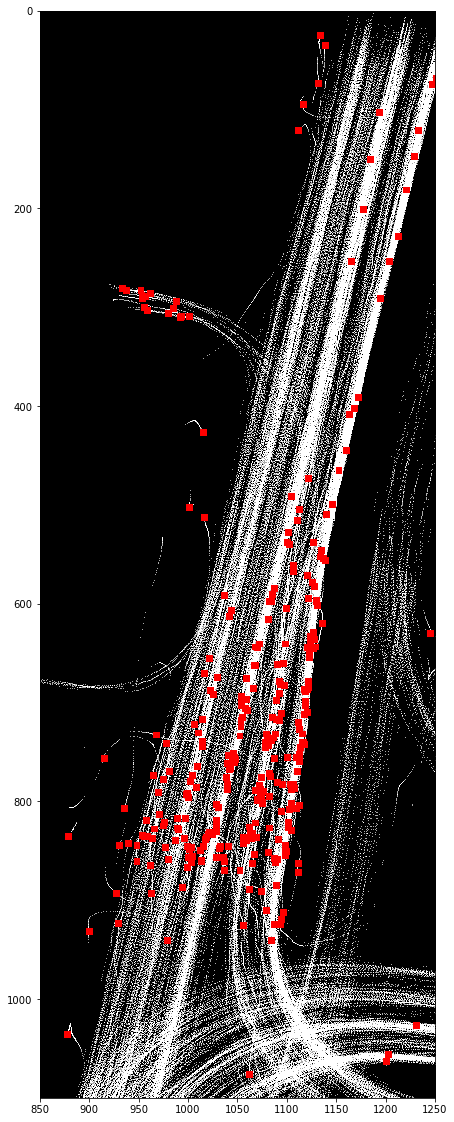

In [26]:
plt.figure(figsize=(40,20))
plt.imshow(im_stop,cmap='gray')
plt.axis([850,1250,1100,0])

The stopped-vehicle data is messy. Stopped vehicles don't seem to stay in particular lane. Some even drive off road and have relatively irregular trajectory shapes.

We suppose that this is due to the presence of motorcycles in the dataset. From the `metadata`, we can see that the number of motorcycles is 671 out of the total 2371 entries.

In [27]:
metadata['type'].value_counts()

Car               1047
Motorcycle         671
Taxi               396
Medium Vehicle     120
Bus                 43
Heavy Vehicle       30
Name: type, dtype: int64

## Removing motorcycles
We now remove motorcycles from the dataset and redo the analysis.


In [28]:
ix_bike = set(metadata[metadata['type'] == 'Motorcycle'].index)
ix_nobike = set(metadata.index) - ix_bike
nobikes = data.loc[ix_nobike]

Redrawing the image of traffic flow:

In [29]:
im_nobikes, im_nobikes_array = create_traffic_heatmap(nobikes[['N','E']],sat_count=2,min_count=2)

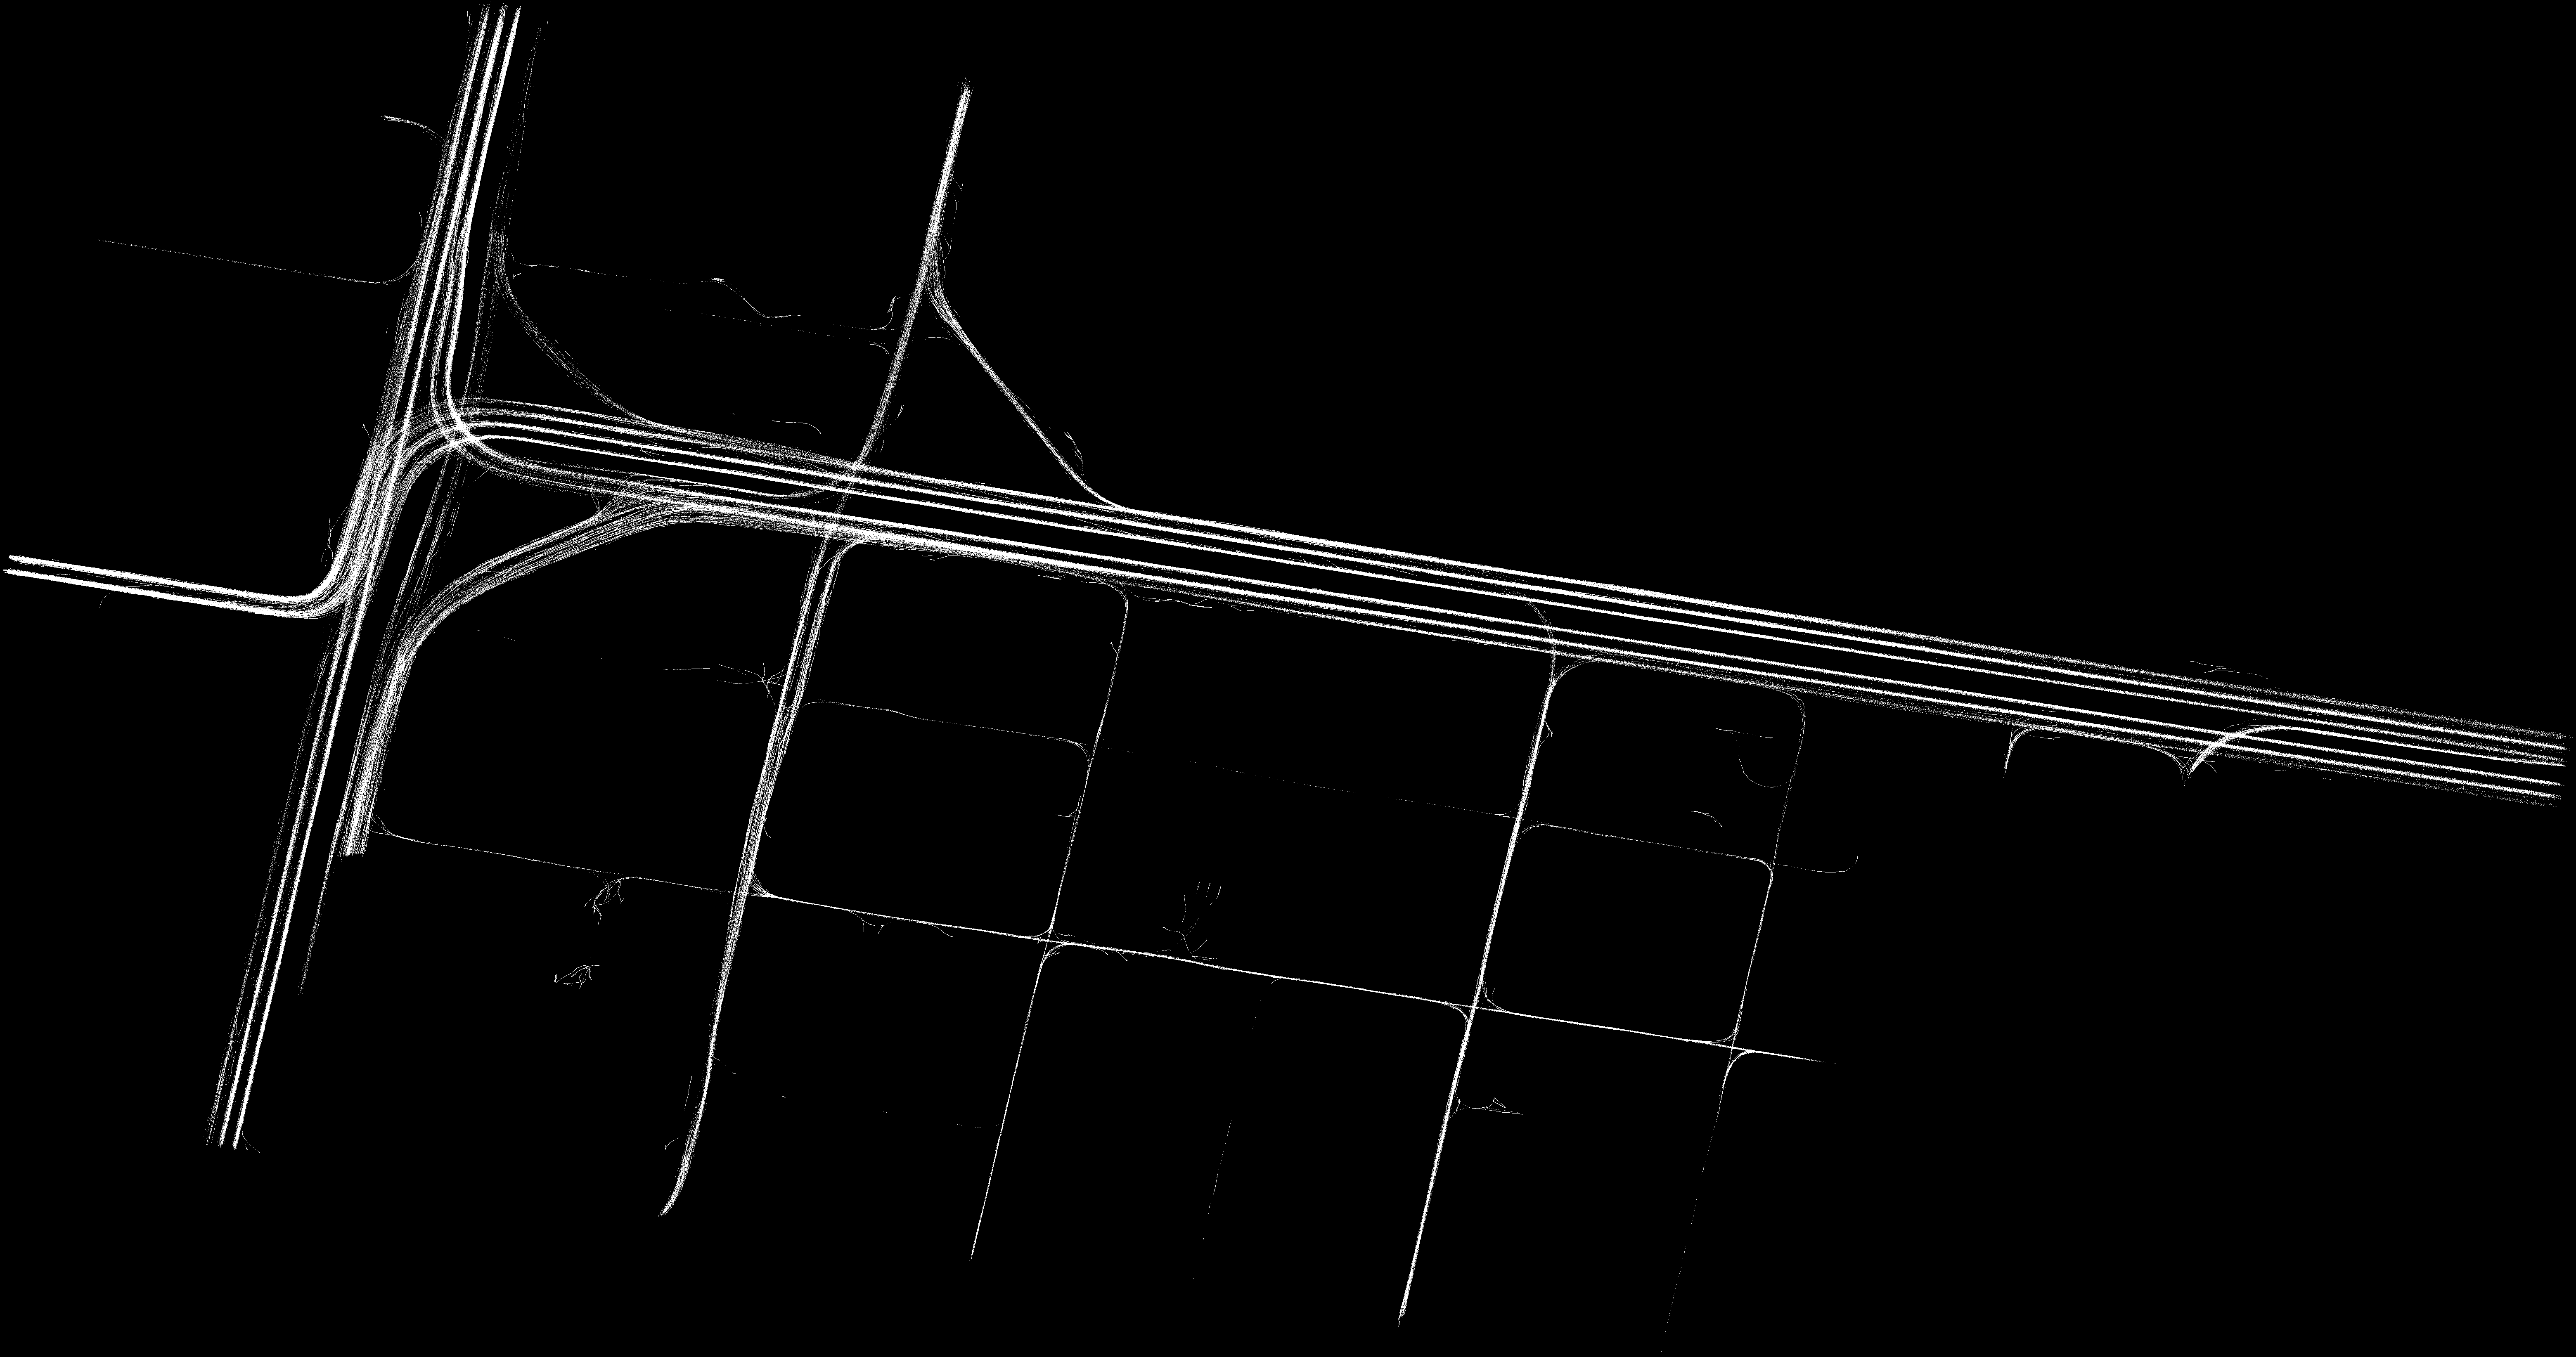

In [30]:
display(im_nobikes)

The image is already a lot cleaner. We now plot the locations of stopped vehicles on top of this image, differentiating between motorcycles and the rest.

In [31]:
bikes = data.loc[ix_bike]
stop_filt_bike = bikes['speed'] < threshold
stop_filt_nobike = nobikes['speed'] < threshold
_, im_bikestop_array = create_traffic_pointsmap(bikes[stop_filt_bike][['N','E']],np.dstack(3*[im_nobikes_array]),rgbval=[1,0.65,0])    
im_nobikestop, im_nobikestop_array = create_traffic_pointsmap(nobikes[stop_filt_nobike][['N','E']],im_bikestop_array)

[850, 2300, 2000, 0]

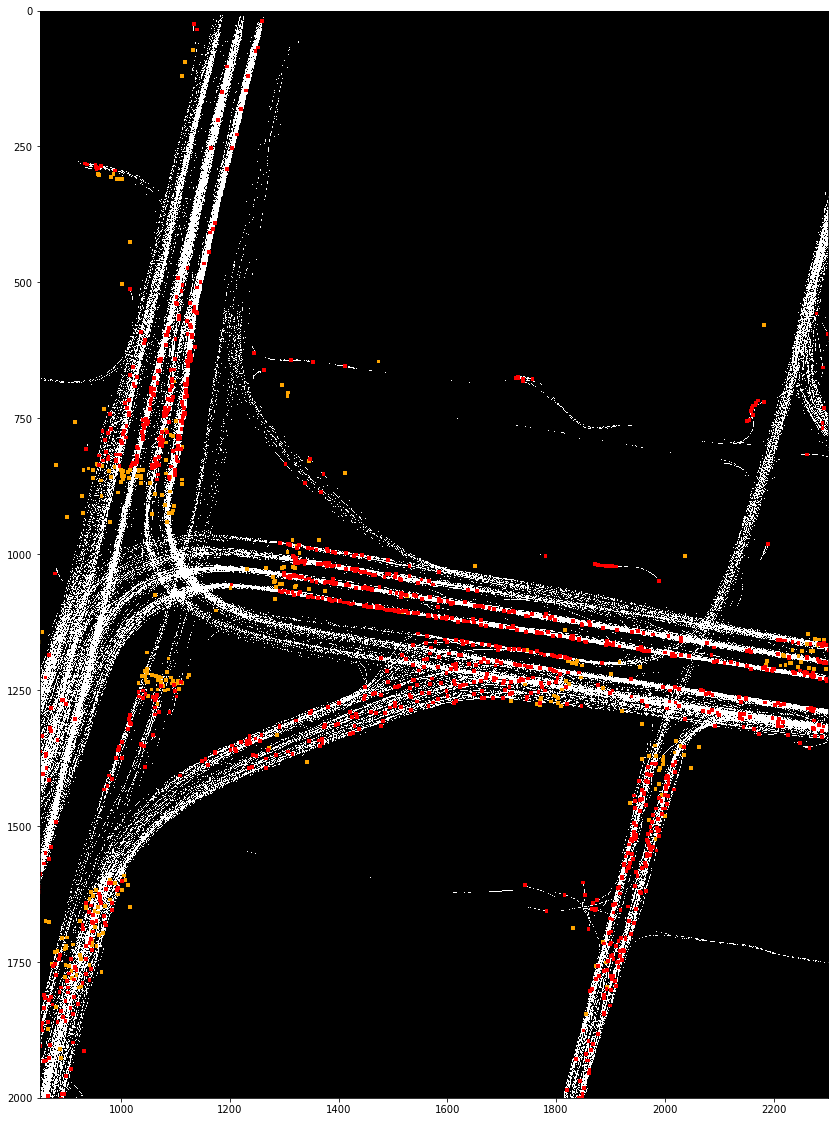

In [32]:
plt.figure(figsize=(40,20))
plt.imshow(im_nobikestop,cmap='gray')
plt.axis([850,2300,2000,0])

From the plot, we can see that our assumption was correct and that motorcycles do not follow queues. They even stop for red lights ahead of the line. We suppose it is fair to say that motorcycles do not participate in queues, and queues are not defined by motorcycle positions. We therefore exclude motorcycles from the dataset and work with the `nobikes` dataframe.

## Utility Functions

In [33]:
def plot_image_with_poly(road_image, polygons, figsize, c, axis):
    plt.figure(figsize=figsize)
    
    plt.imshow(road_image,cmap='gray')
    
    for poly in polygons:
        plt.plot(poly[:,1],poly[:,0],c=c,linewidth=4.0)
    plt.axis(axis)

In [34]:
def contained_inside(pos,poly,lr='right'):
    contains = pos.shape[0]*[True]
    mult = 1 if lr == 'right' else -1
    k = 0
    while k < 4:
        A = poly[k-1]
        AB = poly[k]-A
        contains = contains & (mult*(AB[0]*(pos['E']-A[1])-AB[1]*(pos['N']-A[0])) <= 0)
        k += 1
    return contains

In [35]:
def get_direction_vector(data, step):
    all_diff_vectors = []
    for name, group in data.groupby('track_id')[['N', 'E']]:
        # the difference is taken with the coordinate N time steps ahead
        diff_vectors = group[['N', 'E']].iloc[:-step, :].values - group[['N', 'E']].iloc[step:, :].values
        all_diff_vectors.append(diff_vectors)

    all_diff_vectors = np.concatenate(all_diff_vectors)
    mean_diff = all_diff_vectors.mean(axis=0)
    mean_diff = mean_diff/np.linalg.norm(mean_diff)
    return mean_diff 

In [36]:
def get_rotation_matrix(data, step):
    v = get_direction_vector(data, step)
    rotation = np.asarray([[v[0], -v[1]], [v[1], v[0]]])
    return rotation

In [37]:
def get_kde(data, bandwidth):
    X = np.asarray(data['W'].sort_values()).reshape(-1,1)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X)
    width = np.linspace(data['W'].min(),data['W'].max())
    kde_est = kde.score_samples(width.reshape(-1,1))
    
    min_kde = argrelextrema(kde_est, np.less)[0]
    
    return width, kde_est, min_kde

In [38]:
def get_diff_L(data_stopped, num_lanes):
    diff_L = pd.DataFrame()
    for Lane in range(1,num_lanes+1):
        group = data_stopped[data_stopped['Lane']==Lane]['L'].groupby('frame')
        lane_L_max = group.max()
        lane_L_min = group.min()
        diff_L = diff_L.join((lane_L_max-lane_L_min).rename(Lane), how='outer')

    diff_L.fillna(0)
    return diff_L

In [39]:
def get_results(veh_first, veh_last, frame_max, lane, queue_lane_data, data, ):
    scale_y = dN/(scale*dlat)
    scale_x = dE/(scale*dlon)

    y_dists = scale_y * (queue_lane_data['N'].loc[veh_first:veh_last].diff()).iloc[1:]
    x_dists = scale_x * (queue_lane_data['E'].loc[veh_first:veh_last].diff()).iloc[1:]
    dists = np.linalg.norm(np.asarray([x_dists, y_dists]).T, axis=1)
    piecewise_dist = dists.sum()

    y_dist = scale_y * (data.loc[veh_last,frame_max]['N'] - data.loc[veh_first,frame_max]['N'])
    x_dist = scale_x * (data.loc[veh_last,frame_max]['E'] - data.loc[veh_first,frame_max]['E'])
    dist = np.linalg.norm(np.asarray([x_dist,y_dist]))
    
    coordinates = tuple(data.loc[veh_first,frame_max][['lat','lon']]), tuple(data.loc[veh_last,frame_max][['lat','lon']]) 
    timestamp = data.loc[veh_first,frame_max]['time']
    print('Straight line length (in m): ', 1e3*dist)
    print('Piecewise length (in m):', 1e3*piecewise_dist)
    print('Lane: ', lane)
    print('Coordinates (lat,lon): ', coordinates ) 
    print('Timestamp (s):', timestamp )
    
    return dist, piecewise_dist, coordinates, timestamp

In [40]:
results = {'Region': [], 'Queue Length': [], 'Lane': [], 'Initial Coords.': [], 'Final Coords.': [], 'Time (s)': [], 'Spillback Time (s)': []}
def add_result(name, length, lane, coordinates, time, spillback):
    results['Region'].append(name)
    results['Queue Length'].append(1e3*length)
    results['Lane'].append(lane)
    results['Initial Coords.'].append(coordinates[0])
    results['Final Coords.'].append(coordinates[1])
    results['Time (s)'].append(time)
    results['Spillback Time (s)'].append(spillback)
    

## Green region

We begin with the green region of interest, defining some control points:

In [41]:
green = np.asarray([(860,940), (885,1110), (390,1190), (350,1070)])
green[:,0] = (Nrange-1)-green[:,0]

green_poly = np.append(green,[green[0]],axis=0)
green_poly[:,0] = (Nrange-1)-green_poly[:,0]

Visualizing the green region:

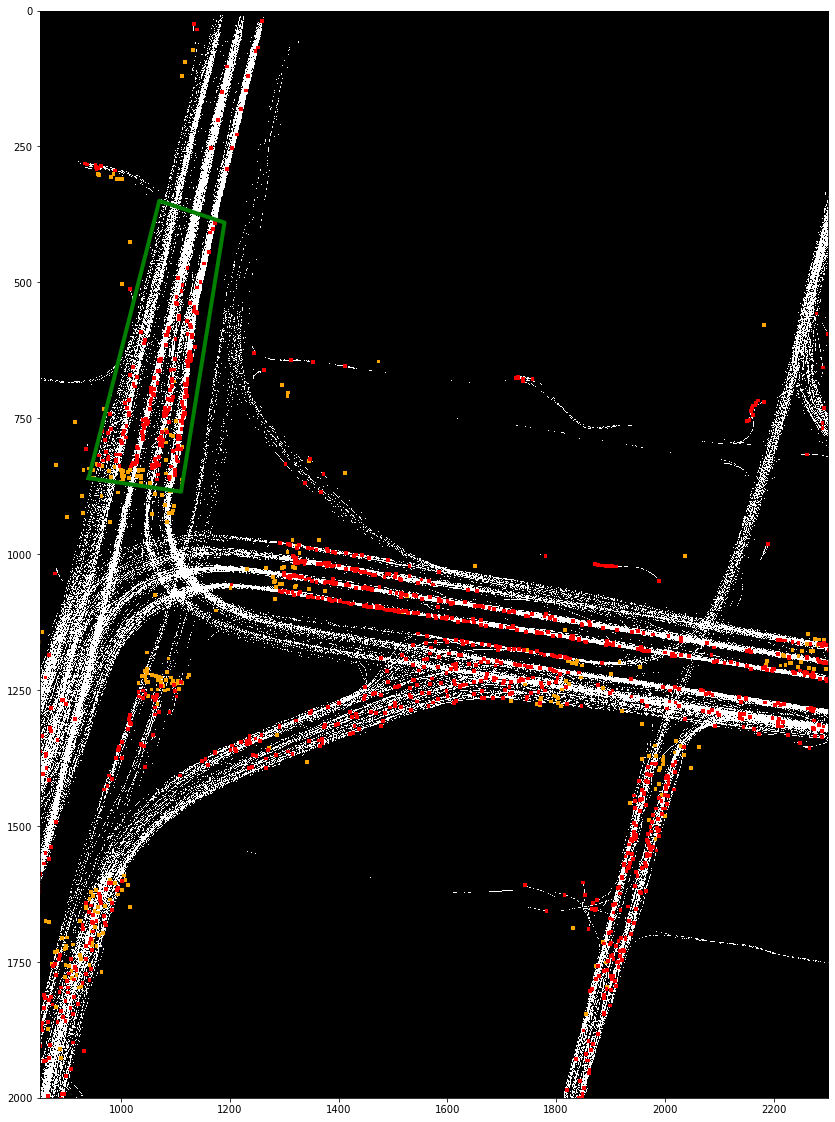

In [42]:
plot_image_with_poly(im_nobikestop, [green_poly], (40, 20), 'g', [850,2300,2000,0])

We create a filter to obtain the points inside a region and apply it to find the points inside the green area.

In [43]:
green_filt = contained_inside(nobikes[['N','E']],green)
green_data = nobikes[green_filt]
green_stop_data = green_data[green_data['speed']<threshold]

In [44]:
green_rotation = get_rotation_matrix(green_data, 10)

We rotate the position data into the appropriate direction.

In [45]:
green_dist_data = (green_data[['N','E']]-green[0]).dot(green_rotation)
green_dist_data.rename(columns={0:'L',1:'W'}, inplace=True)

We want to sort the position into lanes. For this we use kernel density estimation (KDE) on the width `W` column, which runs perpendicular to the data. KDE can be used to find the lane demarcations, by first sorting the data along the perpendicular vector, and then setting the likely location of a lane demarcation to the minimum values of the kernel estimate.

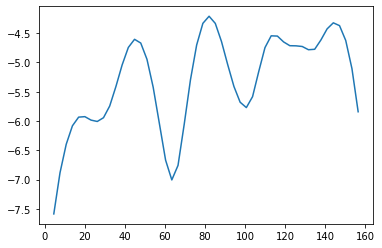

In [46]:
green_width, green_kde_est, min_kde = get_kde(green_dist_data, bandwidth=4)
plt.plot(green_width,green_kde_est)

Sorting the data into lanes:

In [47]:
green_lanes = pd.cut(green_dist_data['W'],green_width[np.concatenate(([0],min_kde,[-1]))],labels=[1,2,3,4,5]).rename('Lane')
green_data_lanes = green_data.join(green_dist_data).join(green_lanes)

In [48]:
green_lanes

track_id  frame
56        0        3
          1        3
          2        3
          3        3
          4        3
                  ..
2280      20231    3
          20232    3
          20233    3
          20234    3
          20235    3
Name: Lane, Length: 263729, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

Plotting the data and coloring according to lane:

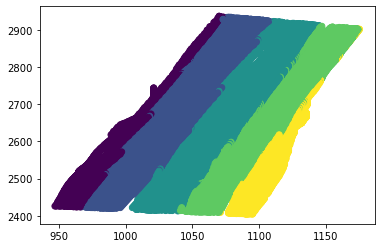

In [49]:
plt.scatter(green_data['E'],green_data['N'],c=green_lanes)

We believe this is an adequate clustering into lanes because vehicles tend to sort themselves into lanes when they are stopped and we are only interested in stopped vehicles.

We continue by sorting vehicles by `L` in each lane. We also take the step of joining Lane 5 data into Lane 4 because the Lane 5 queue will merge into the Lane 4 queue.

In [50]:
green_data_lanes['Lane'] = green_data_lanes['Lane'].map({5:4}).fillna(green_data_lanes['Lane'])

Continue by only considering stopped vehicles:

In [51]:
green_data_stopped = green_data_lanes[green_data_lanes['speed']<threshold]

Finding the difference between the maximum and minimum lengths in all lanes:

In [52]:
diff_L = get_diff_L(green_data_stopped, 4)

In [53]:
print(diff_L.max())

1     95.897328
2    191.284595
3    324.168048
4    331.817082
dtype: float64


The maximum `L` is given in Lane 4. Getting the relevant frame:

In [54]:
frame_max = diff_L[4].idxmax()

In [55]:
frame = frame_max
_, im_greenmid_array = create_traffic_pointsmap(green_data.xs(frame, level='frame')[['N','E']],np.dstack(3*[im_nobikes_array]),rgbval=[0,1,0])    
im_greenstop, im_greenstop_array = create_traffic_pointsmap(green_stop_data.xs(frame, level='frame')[['N','E']],im_greenmid_array)    

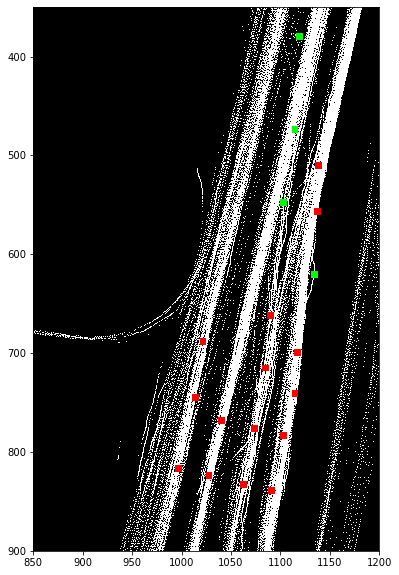

In [56]:
plot_image_with_poly(im_greenstop, [], (20, 10), 'g', [850,1200,900,350])

The image shows moving vehicles in green and stopped vehicles in red. We can see that the queue in Lane 4 is not yet stopped because a vehicle is moving. Checking the relevant frame:

In [57]:
green_data_lanes.xs(frame_max, level='frame')['speed']

track_id
854      0.0000
981      0.0000
994      0.0000
1003     0.0000
1007     0.0000
1012     0.0000
1015     0.0000
1017     0.0000
1019     0.0000
1022     0.0000
1028     0.0000
1029     0.0768
1030     0.0000
1033     0.0000
1037     0.0000
1038     0.0000
1050    10.0801
1052    14.4960
1055    17.3554
Name: speed, dtype: float64

It seems like vehicle `1029` is moving very slowly. Let's check if, when it stops, the queue is still there:

In [58]:
time_max = green_data.loc[1029,frame_max]['time']
frame_max_new = green_data.loc[1029][green_data.loc[1029]['time'] > time_max]['speed'].idxmin()
print(frame_max,frame_max_new)

7666 7697


It takes less than a second for the vehicle to come to a full stop. Redrawing:

In [59]:
frame = frame_max_new
_, im_greenmid_array = create_traffic_pointsmap(green_data.xs(frame, level='frame')[['N','E']],np.dstack(3*[im_nobikes_array]),rgbval=[0,1,0])    
im_greenstop, im_greenstop_array = create_traffic_pointsmap(green_stop_data.xs(frame, level='frame')[['N','E']],im_greenmid_array)    

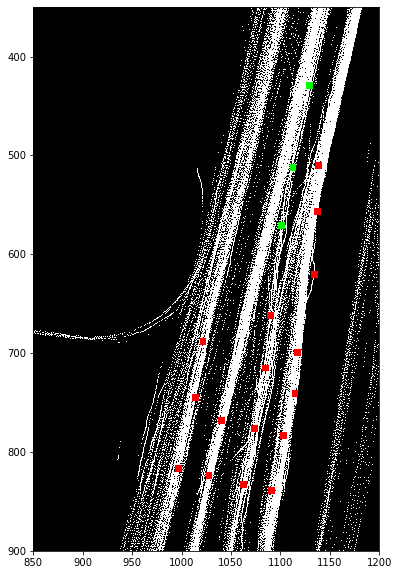

In [60]:
plot_image_with_poly(im_greenstop, [], (20, 10), 'g', [850,1200,900,350])

We now have enough information to give an answer. 

In [61]:
green_data_lanes[green_data_lanes['Lane']==4].xs(frame_max_new, level='frame').sort_values('L')

,lat,lon,speed,lat_acc,lon_acc,time,N,E,L,W,Lane
track_id,,,,,,,,,,,
981,37.991971,23.731369,0.0,0.0,0.0,307.88,2448,1091,51.755165,143.399452,4
1007,37.991977,23.731341,0.0,0.0,0.0,307.88,2454,1063,51.838595,114.763932,4
994,37.992027,23.731381,0.0,0.0,0.0,307.88,2504,1103,109.026206,143.566314,4
1015,37.992034,23.731352,0.0,0.0,0.0,307.88,2511,1074,109.881366,113.745705,4
1003,37.992069,23.731393,0.0,0.0,0.0,307.88,2546,1115,152.599525,146.626686,4
1019,37.992095,23.731363,0.0,0.0,0.0,307.88,2572,1085,171.837771,111.900761,4
1012,37.992111,23.731396,0.0,0.0,0.0,307.88,2588,1118,194.312729,140.881380,4
1028,37.992148,23.731368,0.0,0.0,0.0,307.88,2625,1090,224.726831,105.838800,4
1029,37.992190,23.731413,0.0,-0.0,-0.0,307.88,2667,1135,275.120568,141.186660,4


We find that the IDs of the first and last vehicles in the queue are `1007` and `854`, respectively. The answers we record are:

In [62]:
queue_lane_data = green_data_lanes[green_data_lanes['Lane']==4].xs(frame_max_new, level='frame').sort_values('L')

In [63]:
veh_first = 1007
veh_last = 854
lane = 4
dist, piecewise_dist, coordinates, timestamp =  get_results(veh_first, veh_last, frame_max_new, lane, queue_lane_data, green_data, )

Straight line length (in m):  36.4681132260529
Piecewise length (in m): 44.95192453299394
Lane:  4
Coordinates (lat,lon):  ((37.991977, 23.731341), (37.9923, 23.731417))
Timestamp (s): 307.88


In [64]:
add_result('Green', piecewise_dist, lane, coordinates, timestamp, None)

## Red region

We continue with the red region, defining a control region, a predominant direction, and a visualization.

In [65]:
red = np.asarray([(1075,1260), (960,1275), (1570,5075), (1675,5040)])
red[:,0] = (Nrange-1)-red[:,0]

red_poly = np.append(red,[red[0]],axis=0)
red_poly[:,0] = (Nrange-1)-red_poly[:,0]

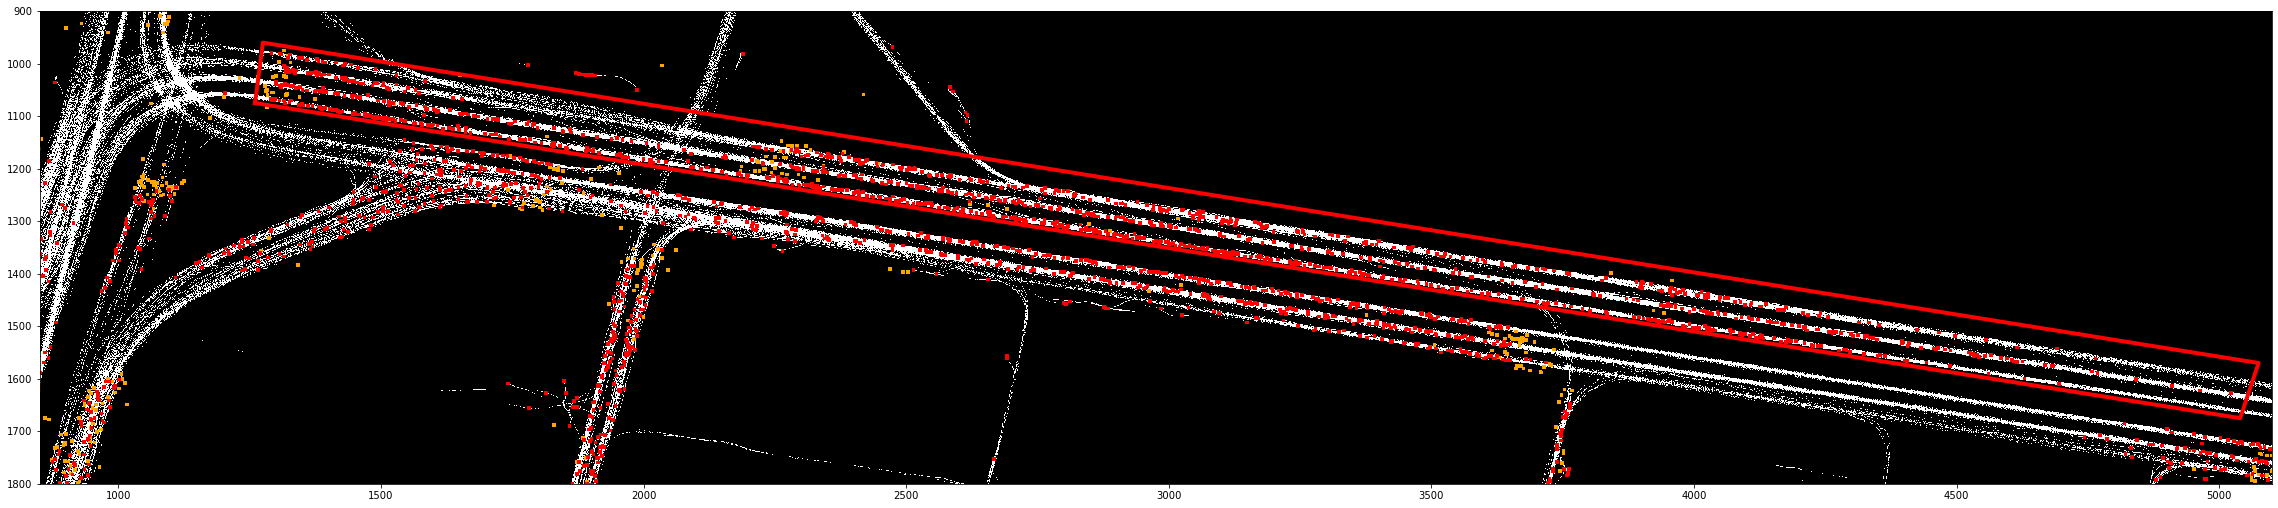

In [66]:
plot_image_with_poly(im_nobikestop, [red_poly], (40,20), 'r', [850,5100,1800,900])

We filter the data and cluster into lanes.

In [67]:
red_filt = contained_inside(nobikes[['N','E']],red,lr='left')
red_data = nobikes[red_filt]
red_stop_data = red_data[red_data['speed']<threshold]

In [68]:
red_rotation = get_rotation_matrix(red_data, step=200)

In [69]:
red_dist_data = (red_data[['N','E']]-red[0]).dot(red_rotation)
red_dist_data.rename(columns={0:'L',1:'W'}, inplace=True)
red_data = red_data.join(red_dist_data)

In [70]:
red_dist_data

L          W
track_id frame                        
57       1638    727.805085  -5.455079
         1639    729.615794  -6.767075
         1640    732.413185  -8.241728
         1641    734.223894  -9.553725
         1642    736.034603 -10.865721
...                     ...        ...
2266     20231  3773.452126 -90.989306
         20232  3772.302786 -91.813332
         20233  3770.329421 -91.488018
         20234  3768.356056 -91.162705
         20235  3767.206716 -91.986731

[1371372 rows x 2 columns]

In [71]:
red_width, red_kde_est, min_kde = get_kde(red_dist_data, 1.25)

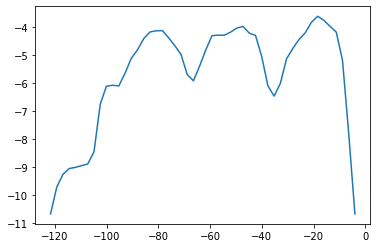

In [72]:
plt.plot(red_width,red_kde_est)

In [73]:
min_kde

array([11, 23, 36])

We can see 4 lanes in the data, with Lane 1 being less prominent because it results from the splitting of Lane 1 into 2 lanes. We sort the data into lanes. 

In [74]:
red_lanes = pd.cut(red_dist_data['W'],red_width[np.concatenate(([0],min_kde,[-1]))],labels=[1,2,3,4]).rename('Lane')
red_data_lanes = red_data.join(red_lanes)

In [75]:
red_data_lanes

lat        lon    speed  lat_acc  lon_acc    time     N  \
track_id frame                                                                  
57       1638   37.991622  23.732257  20.9152   0.1564  -1.9199   65.52  2099   
         1639   37.991623  23.732259  20.9390   0.1740  -1.8960   65.56  2100   
         1640   37.991624  23.732262  20.9654   0.1927  -1.8722   65.60  2101   
         1641   37.991625  23.732264  20.9939   0.2039  -1.8489   65.64  2102   
         1642   37.991626  23.732266  21.0237   0.2091  -1.8261   65.68  2103   
...                   ...        ...      ...      ...      ...     ...   ...   
2266     20231  37.991211  23.735276  13.7524  -0.1701   0.0886  809.24  1688   
         20232  37.991212  23.735275  13.7233  -0.1134   0.0841  809.28  1689   
         20233  37.991212  23.735273  13.6989  -0.0772   0.0795  809.32  1689   
         20234  37.991212  23.735271  13.6793  -0.0166   0.0750  809.36  1689   
         20235  37.991213  23.735270  13.6685   0.0739   0.0704  809.40  1690   

                   E            L          W Lane  
track_id frame                                     
57       1638   1979   727.805085  -5.455079    4  
         1639   1981   729.615794  -6.767075    4  
         1640   1984   732.413185  -8.241728    4  
         1641   1986   734.223894  -9.553725    4  
         1642   1988   736.034603 -10.865721    4  
...              ...          ...        ...  ...  
2266     20231  4998  3773.452126 -90.989306    2  
         20232  4997  3772.302786 -91.813332    2  
         20233  4995  3770.329421 -91.488018    2  
         20234  4993  3768.356056 -91.162705    2  
         20235  4992  3767.206716 -91.986731    2  

[1371372 rows x 11 columns]

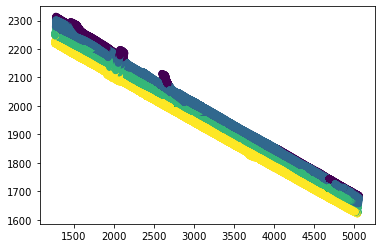

In [76]:
plt.scatter(red_data['E'],red_data['N'],c=red_lanes)

As for the green region, we believe this is an adequate clustering into lanes.

We continue by sorting vehicles by `L` in each lane.

In [77]:
red_data_stopped = red_data_lanes[red_data_lanes['speed']<threshold]

diff_L = get_diff_L(red_data_stopped, len(min_kde)+2)

In [78]:
diff_L.max()

1     206.640205
2    3756.669304
3    3692.935436
4    3447.814605
5            NaN
dtype: float64

In [79]:
frame_max = diff_L.idxmax()[3]

In [80]:
frame = frame_max
_, im_redmid_array = create_traffic_pointsmap(red_data.xs(frame, level='frame')[['N','E']],np.dstack(3*[im_nobikes_array]),rgbval=[0,1,0])    
im_redstop, im_redstop_array = create_traffic_pointsmap(red_stop_data.xs(frame, level='frame')[['N','E']],im_redmid_array)    

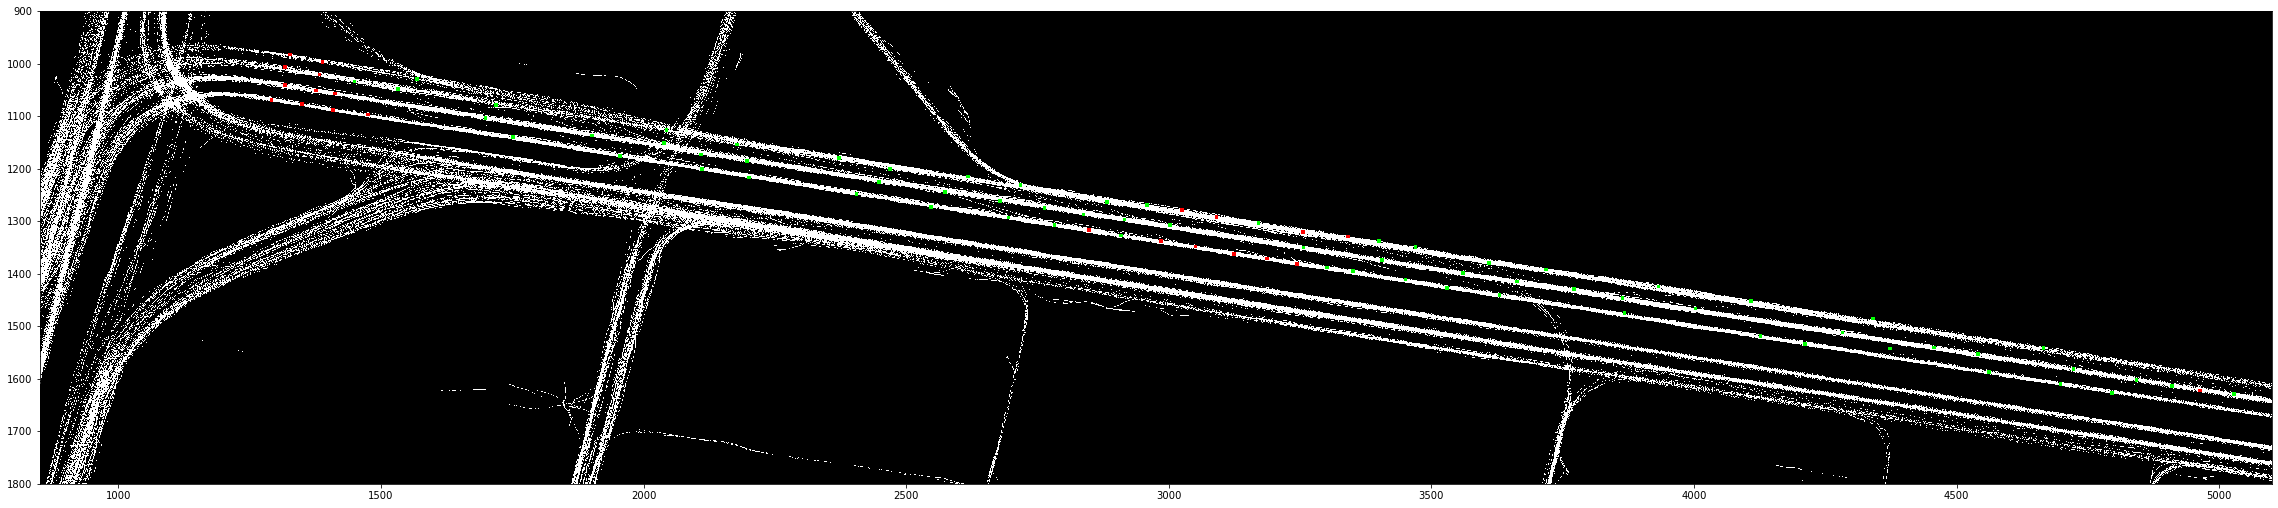

In [81]:
plot_image_with_poly(im_redstop, [], (40, 20), 'r', [850,5100,1800,900])

From the image, we can see that `frame_max` does not contain any large queues. The problem we have run into is that, due to the length of the red region, there can be a long gap between stopped vehicles and measuring the distance between the first stopped vehicle and the last stopped vehicle does not give the length of a queue.

To solve this, we sort the data by `L`, looking for the longest streaks of stopped vehicles.

In [82]:
stop_filt = red_data_lanes['speed']<threshold
red_sorted = red_data_lanes[stop_filt].sort_values(by=['Lane','frame','L'])
red_sorted = red_sorted.reset_index().set_index(['frame','track_id'])

We consider a good distance between stopped vehicles to be about and `L = 200`, guided by the histogram below.

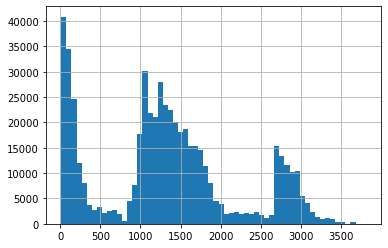

In [83]:
red_sorted['L'].hist(bins=60)

We now look for the longest streak by creating a mask and then applying it to a new dataframe.

In [84]:
streaking = red_sorted['L'].diff().le(200) & red_sorted['time'].diff().le(1e-2)
streak = pd.DataFrame(streaking.cumsum().rename('total'))
streak.loc[~streaking,'cs'] = streak['total']
streak['cs'].fillna(method='ffill',inplace=True)
streak['streak'] = streak['total']-streak['cs']

In [85]:
max_streak = streak['streak'].max()
print(max_streak)

16.0


The maximum streak is obtained at frame:

In [86]:
frame_max_streak = streak['streak'].idxmax()[0]
print(frame_max_streak)

19772


Plotting:

In [87]:
frame = frame_max_streak
_, im_redmid_array = create_traffic_pointsmap(red_data.xs(frame, level='frame')[['N','E']],np.dstack(3*[im_nobikes_array]),rgbval=[0,1,0])    
im_redstop, im_redstop_array = create_traffic_pointsmap(red_stop_data.xs(frame, level='frame')[['N','E']],im_redmid_array)    

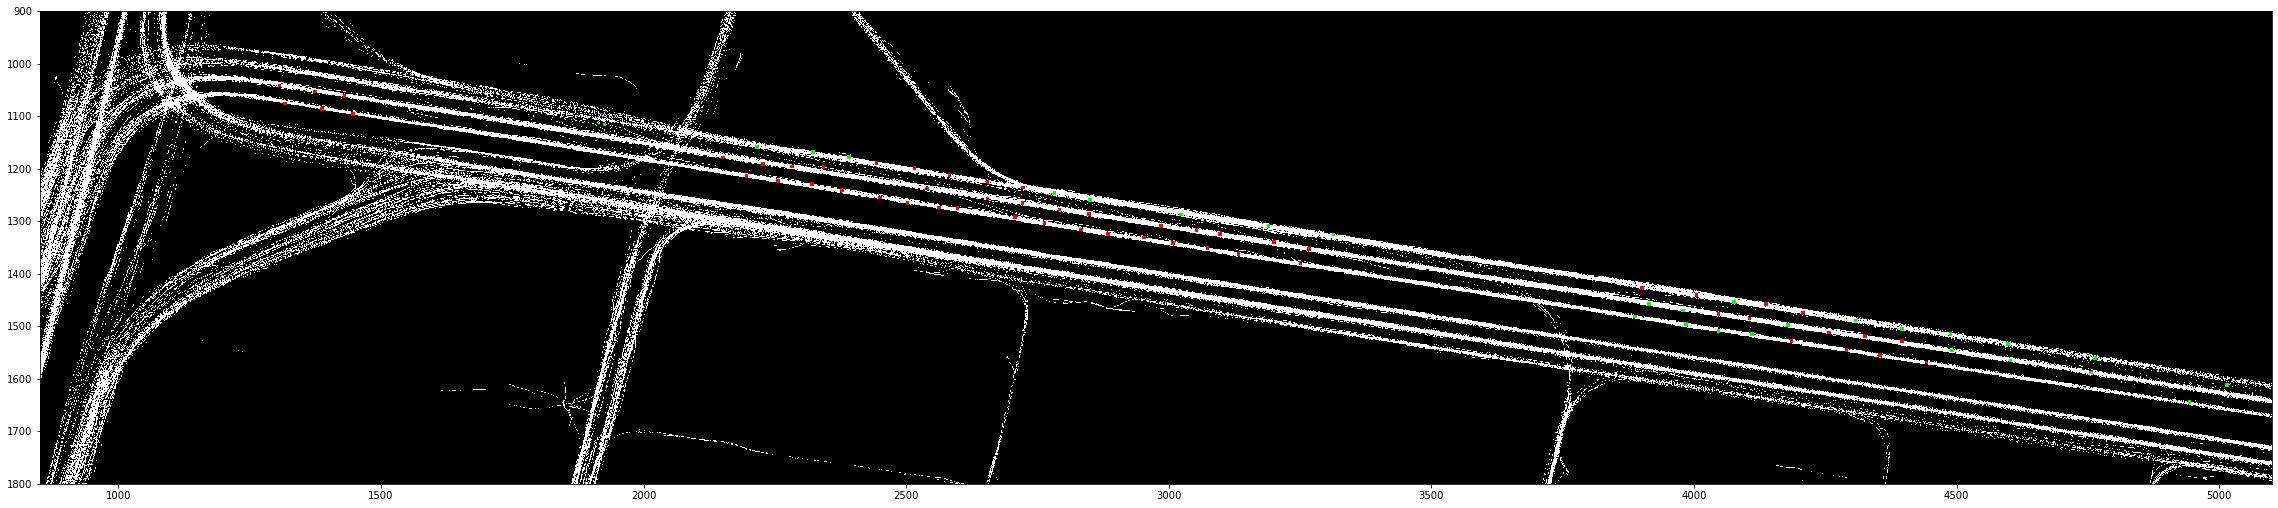

In [88]:
plot_image_with_poly(im_redstop, [], (40, 20), 'r', [850,5100,1800,900])

By inpection, we see that the longest queue occurs in Lane 2 (we have thus far referred to Lane 2 as Lane 3 because Lane 1 splits into two). To find the required data, we take a look at the dataframe.

In [89]:
queue_lane_data = red_sorted[red_sorted['Lane']==3].loc[frame_max_streak]

In [90]:
queue_lane_data

,lat,lon,speed,lat_acc,lon_acc,time,N,E,L,W,Lane
track_id,,,,,,,,,,,
1686,37.991768,23.731584,0.0,0.0,0.0,790.88,2245,1306,40.019731,-40.042741,3
1730,37.991757,23.731651,0.0,0.0,0.0,790.88,2234,1373,107.916697,-40.087236,3
1735,37.991748,23.731708,0.0,0.0,0.0,790.88,2225,1430,165.621523,-40.478528,3
1758,37.991631,23.732428,0.0,0.0,0.0,790.88,2108,2150,895.063918,-42.149533,3
1890,37.991619,23.732505,0.0,0.0,0.0,790.88,2096,2227,972.990368,-42.833913,3
1894,37.991614,23.732560,0.0,0.0,0.0,790.88,2091,2282,1028.071201,-46.846622,3
1866,37.991613,23.732620,0.0,0.0,0.0,790.88,2090,2342,1087.434820,-55.619346,3
1885,37.991572,23.732817,0.0,0.0,0.0,790.88,2049,2539,1288.480242,-47.208741,3
1900,37.991553,23.732932,0.0,0.0,0.0,790.88,2030,2654,1405.039233,-47.167299,3


In [91]:
red_lane3 = red_sorted[red_sorted['Lane']==3].loc[frame_max_streak]['L']
display(red_lane3)

track_id
1686      40.019731
1730     107.916697
1735     165.621523
1758     895.063918
1890     972.990368
1894    1028.071201
1866    1087.434820
1885    1288.480242
1900    1405.039233
1919    1472.448229
1950    1543.630557
1949    1600.186043
1959    1740.089363
1970    1807.498359
1927    1853.037678
2006    1957.268506
2011    2024.504103
2049    2814.123401
2054    2873.801592
2092    3027.182415
2100    3096.239462
2125    3166.933820
Name: L, dtype: float64

We see that the IDs of the first and last vehicles are `1828` and `1943`, respectively. The answers we record are:

In [92]:
frame_max_streak

19772

In [93]:
veh_first = 1758
veh_last = 2011
lane = 3
dist, piecewise_dist, coordinates, timestamp =  get_results(veh_first, veh_last, frame_max_streak, lane, queue_lane_data, red_data, )

Straight line length (in m):  99.91927226588018
Piecewise length (in m): 100.07473996312194
Lane:  3
Coordinates (lat,lon):  ((37.991631, 23.732428), (37.991457, 23.733544))
Timestamp (s): 790.88


In [94]:
add_result('Red', piecewise_dist, lane, coordinates, timestamp, None)

In [95]:
results

{'Region': ['Green', 'Red'],
 'Queue Length': [44.95192453299394, 100.07473996312194],
 'Lane': [4, 3],
 'Initial Coords.': [(37.991977, 23.731341), (37.991631, 23.732428)],
 'Final Coords.': [(37.9923, 23.731417), (37.991457, 23.733544)],
 'Time (s)': [307.88, 790.88],
 'Spillback Time (s)': [None, None]}

## Yellow region
.
We continue with the yellow region, performing the analysis in the same way as for the red region. We ignore the diagonal part of the road to see if we can obtain anything meaningful.

In [96]:
yellow = np.asarray([(1290,1855), (1180,1865), (1125,1490), (1225,1450)])
yellow[:,0] = (Nrange-1)-yellow[:,0]

yellow_poly = np.append(yellow,[yellow[0]],axis=0)
yellow_poly[:,0] = (Nrange-1)-yellow_poly[:,0]

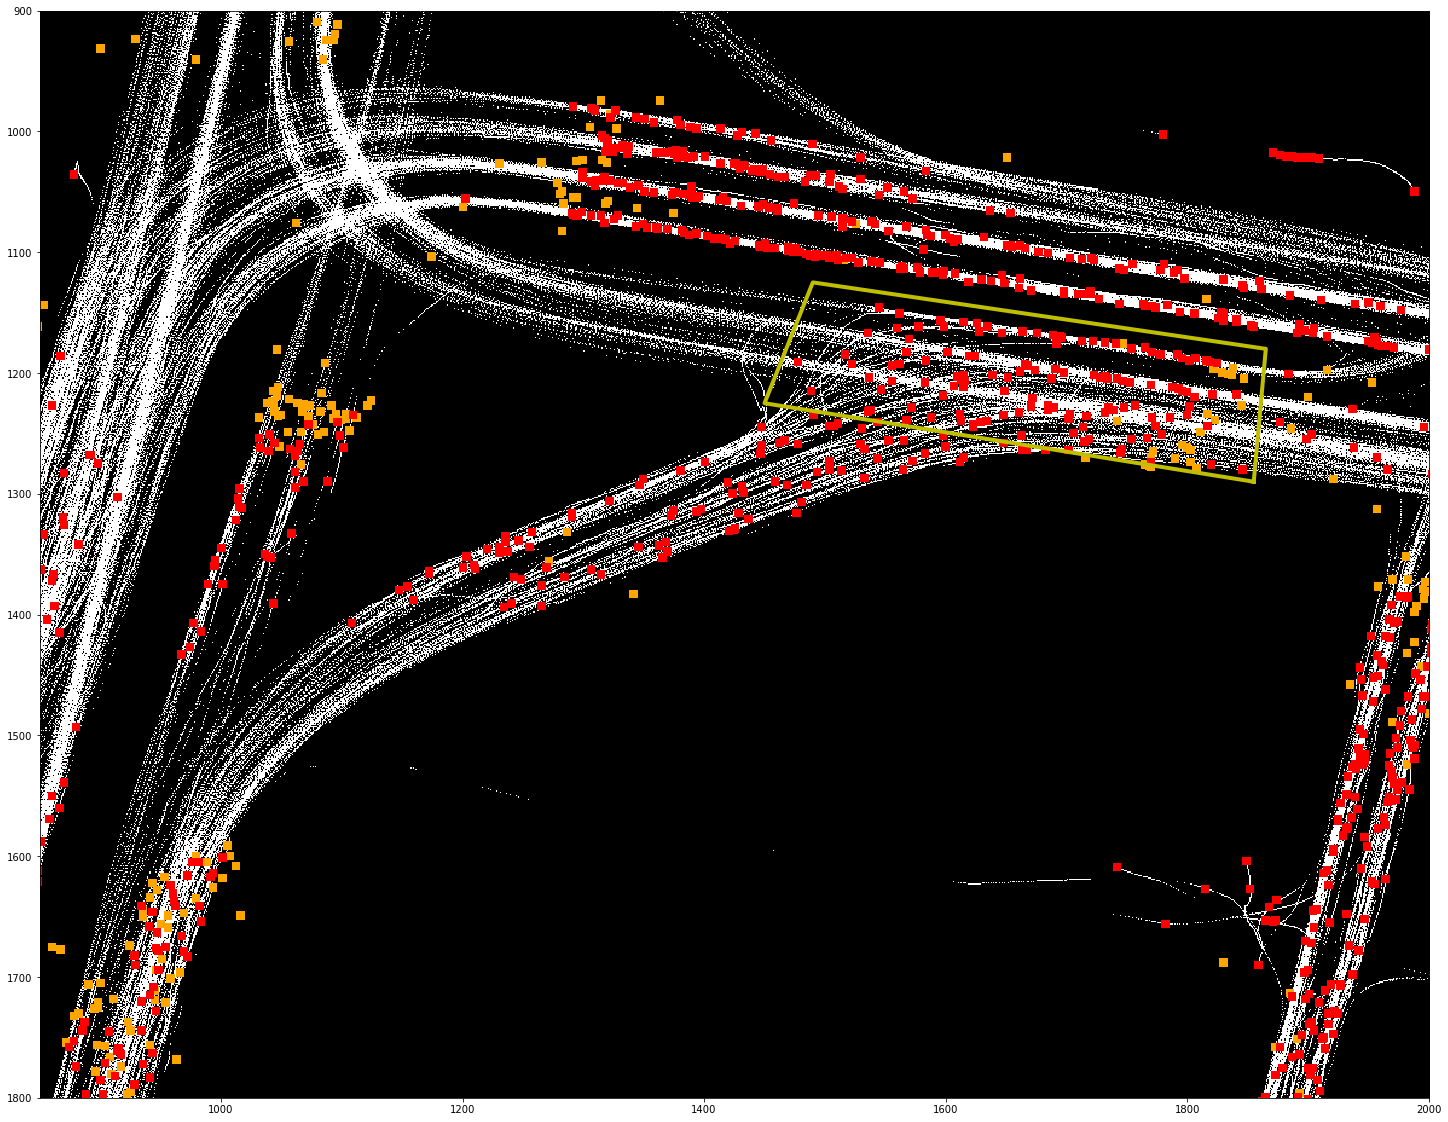

In [97]:
plot_image_with_poly(im_nobikestop, [yellow_poly], (40, 20), 'y', [850,2000,1800,900])


In [98]:
yellow_filt = contained_inside(nobikes[['N','E']],yellow)
yellow_data = nobikes[yellow_filt]

Looking at the data in yellow region, we see that the cars don't align well to extract a rotation vector based solely on their difference vectors. We manually define lane direction below:

In [99]:
yellow_direction = yellow[3] - yellow[0]
v = yellow_direction / np.linalg.norm(yellow_direction)

yellow_rotation = np.asarray([[v[0], -v[1]], [v[1], v[0]]])

In [100]:
yellow_stop_data = yellow_data[yellow_data['speed']<threshold]
yellow_dist_data = (yellow_data[['N','E']]-yellow[0]).dot(yellow_rotation)
yellow_dist_data.rename(columns={0:'L',1:'W'}, inplace=True)
yellow_data = yellow_data.join(yellow_dist_data)

In [101]:
yellow_width, yellow_kde_est, min_kde = get_kde(yellow_dist_data, 3)

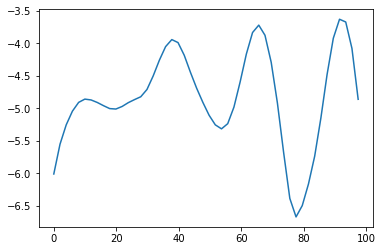

In [102]:
plt.plot(yellow_width,yellow_kde_est)

In [103]:
yellow_lanes = pd.cut(yellow_dist_data['W'],yellow_width[np.concatenate(([0],min_kde,[-1]))],labels=[1,2,3,4]).rename('Lane')
yellow_data_lanes = yellow_data.join(yellow_lanes)

In [104]:
yellow_data_lanes

lat        lon    speed  lat_acc  lon_acc    time     N  \
track_id frame                                                                  
49       0      37.991587  23.731971  32.8520   0.0078   0.0727    0.00  2064   
         1      37.991586  23.731975  32.8525  -0.0018   0.0839    0.04  2063   
         2      37.991586  23.731979  32.8518  -0.0078   0.0950    0.08  2063   
         3      37.991585  23.731983  32.8502  -0.0137   0.1062    0.12  2062   
         4      37.991585  23.731987  32.8474  -0.0251   0.1173    0.16  2062   
...                   ...        ...      ...      ...      ...     ...   ...   
2183     19976  37.991608  23.732133  15.9991   0.4549  -0.5125  799.04  2085   
         19977  37.991608  23.732135  16.0657   0.4693  -0.5435  799.08  2085   
         19978  37.991608  23.732137  16.1338   0.4763  -0.5762  799.12  2085   
         19979  37.991608  23.732139  16.2034   0.4905  -0.6105  799.16  2085   
         19980  37.991608  23.732141  16.2755   0.5119  -0.6465  799.20  2085   

                   E           L          W Lane  
track_id frame                                    
49       0      1693  170.570256  40.481942    2  
         1      1697  166.462333  40.128442    2  
         2      1701  162.512875  40.762305    2  
         3      1705  158.404951  40.408804    2  
         4      1709  154.455493  41.042668    2  
...              ...         ...        ...  ...  
2183     19976  1855   13.944999  86.888072    4  
         19977  1857   11.970270  87.205003    4  
         19978  1859    9.995541  87.521935    4  
         19979  1861    8.020812  87.838867    4  
         19980  1863    6.046084  88.155799    4  

[142677 rows x 11 columns]

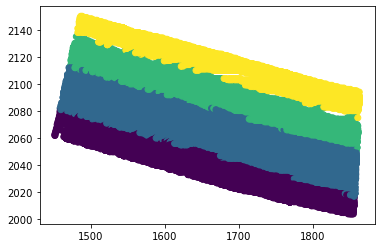

In [105]:
plt.scatter(yellow_data['E'],yellow_data['N'],c=yellow_lanes)

In [106]:
yellow_data_stopped = yellow_data_lanes[yellow_data_lanes['speed']<threshold]
diff_L = get_diff_L(yellow_data_stopped, len(min_kde)+2)

In [107]:
frame_max = diff_L.idxmax()[1]

In [108]:
frame = frame_max
_, im_yellowmid_array = create_traffic_pointsmap(yellow_data.xs(frame, level='frame')[['N','E']],np.dstack(3*[im_nobikes_array]),rgbval=[0,1,0])    
im_yellowstop, im_yellowstop_array = create_traffic_pointsmap(yellow_stop_data.xs(frame, level='frame')[['N','E']],im_yellowmid_array)    

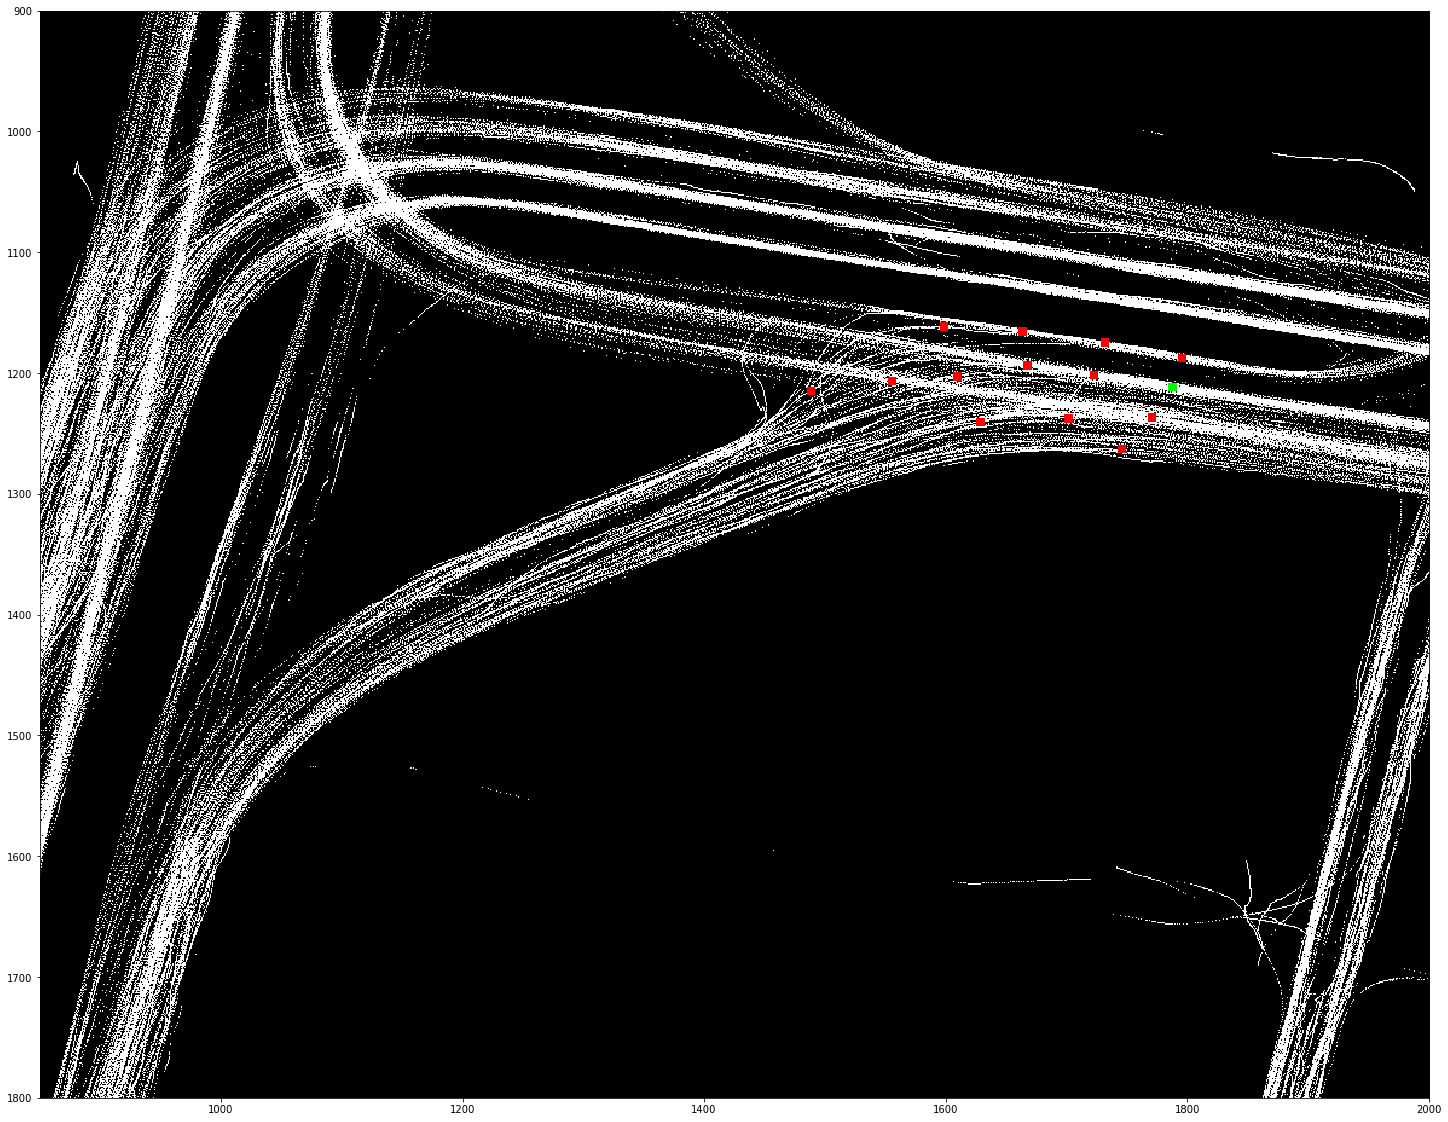

In [109]:
plot_image_with_poly(im_yellowstop, [], (40, 20), 'y', [850,2000,1800,900])

The result we get does not make a lot of sense. The vehicles clearly do not follow the lanes as they are coming in from the diagonal road and merging. For this reason, we split the yellow region into two yellow regions: `yellow1` and `yellow2`.

In [110]:
yellow2 = np.asarray([(1485,1120), (1380,1080), (1225,1450), (1335,1500)])  # (1225,1450)])
yellow2[:,0] = (Nrange-1)-yellow2[:,0]

yellow1 = np.asarray([yellow[0], yellow[1], yellow[2], yellow2[2], yellow2[3]])

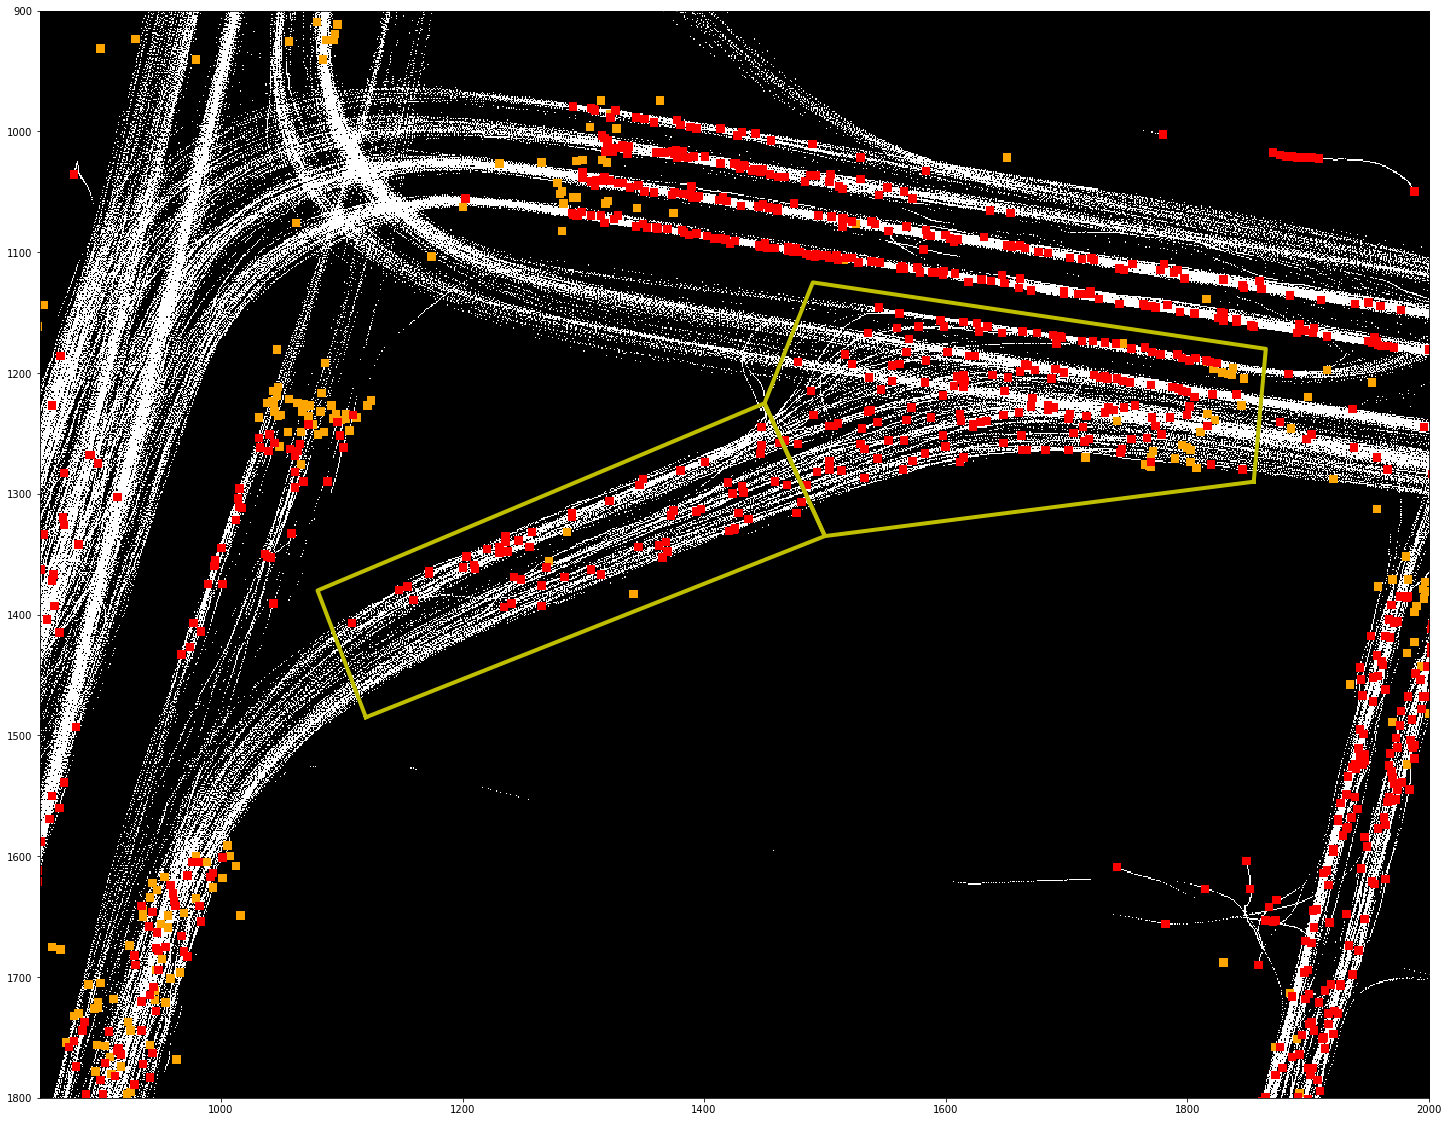

In [111]:
yellow1_poly = np.append(yellow1,[yellow1[0]],axis=0)
yellow1_poly[:,0] = (Nrange-1)-yellow1_poly[:,0]

yellow2_poly = np.append(yellow2,[yellow2[0]],axis=0)
yellow2_poly[:,0] = (Nrange-1)-yellow2_poly[:,0]

plot_image_with_poly(im_nobikestop, [yellow1_poly, yellow2_poly], (40, 20), 'y', [850,2000,1800,900])

We now perform the analysis on the `yellow2` region, but filter out all frames where there is a moving vehicle in `yellow1`. In this way, we guarantee that the first region is overloaded and we will be left with the data with the most congestion.

In [112]:
yellow2_filt = contained_inside(nobikes[['N','E']],yellow2,lr='left')
yellow2_data = nobikes[yellow2_filt]
yellow1_filt = contained_inside(nobikes[['N','E']],yellow1)
yellow1_data = nobikes[yellow1_filt]
yellow1_go_frames = set(yellow1_data[yellow1_data['speed'] > 0].index.get_level_values('frame'))
yellow2_data = yellow2_data[~yellow2_data.index.isin(yellow1_go_frames, level='frame')]

Manual definition of direction vectors

In [113]:
yellow1_direction = np.asarray((0.75*yellow1[4]+ 0.25*yellow1[3]) - yellow1[1])
v = yellow1_direction / np.linalg.norm(yellow1_direction)
yellow1_rotation = np.asarray([[v[0], -v[1]], [v[1], v[0]]])

yellow2_direction = np.asarray(yellow2[0] - yellow2[3])
v = yellow2_direction / np.linalg.norm(yellow2_direction)
yellow2_rotation = np.asarray([[v[0], -v[1]], [v[1], v[0]]])

In [114]:
yellow2_dist_data = (yellow2_data[['N','E']]-yellow2[0]).dot(yellow2_rotation)
yellow2_dist_data.rename(columns={0:'L',1:'W'}, inplace=True)
yellow2_data = yellow2_data.join(yellow2_dist_data)
yellow2_stop_data = yellow2_data[yellow2_data['speed']<threshold]

It turns out that there aren't that many data points to consider. There are only so many stopped vehicles:

In [115]:
stops_frame = yellow2_stop_data[['N','E']].reset_index().set_index(['N','E']).groupby(['N','E']).last()
print(stops_frame)

           track_id  frame
N    E                    
1910 1154      1971  17785
1924 1306      1488  12728
1925 1210      1953  17785
1938 1230      1085   8794
1941 1220       887   6524
1943 1230      1718  14700
1944 1362      1410  12587
1948 1246      1948  17785
1955 1257      1389  12728
1971 1428      1401  12728
1973 1374      1483  12728
1980 1480      1689  14700
1981 1321      1485  12728
1996 1419      1476  12728
2006 1380      1296  12728
2027 1447      1480  12728


Counting the number of stopped vehicles per frame:

In [116]:
stops_frame['frame'].value_counts()

12728    8
17785    3
14700    2
6524     1
12587    1
8794     1
Name: frame, dtype: int64

In [117]:
yellow2_data_stopped = yellow2_data[yellow2_data['speed']<threshold]

In [118]:
yellow2_data_stopped.sort_values('time')

lat        lon  speed  lat_acc  lon_acc    time     N  \
track_id frame                                                                
887      6480   37.991464  23.731498    0.0     -0.0      0.0  259.20  1941   
         6481   37.991464  23.731498    0.0     -0.0      0.0  259.24  1941   
         6482   37.991464  23.731498    0.0     -0.0      0.0  259.28  1941   
         6483   37.991464  23.731498    0.0     -0.0      0.0  259.32  1941   
         6484   37.991464  23.731498    0.0     -0.0      0.0  259.36  1941   
...                   ...        ...    ...      ...      ...     ...   ...   
1948     17784  37.991471  23.731524    0.0      0.0      0.0  711.36  1948   
1971     17784  37.991433  23.731432    0.0      0.0      0.0  711.36  1910   
1953     17785  37.991448  23.731488    0.0      0.0      0.0  711.40  1925   
1948     17785  37.991471  23.731524    0.0      0.0      0.0  711.40  1948   
1971     17785  37.991433  23.731432    0.0      0.0      0.0  711.40  1910   

                   E           L          W  
track_id frame                               
887      6480   1220 -144.051670  92.574922  
         6481   1220 -144.051670  92.574922  
         6482   1220 -144.051670  92.574922  
         6483   1220 -144.051670  92.574922  
         6484   1220 -144.051670  92.574922  
...              ...         ...        ...  
1948     17784  1246 -170.805872  89.539679  
1971     17784  1154  -71.279263  87.973102  
1953     17785  1210 -128.875454  81.364104  
1948     17785  1246 -170.805872  89.539679  
1971     17785  1154  -71.279263  87.973102  

[1281 rows x 10 columns]

We see that the most congested frame is `12728`.

In [119]:
frame = 12728
_, im_yellowmid_array = create_traffic_pointsmap(yellow1_data.xs(frame, level='frame')[['N','E']],np.dstack(3*[im_nobikes_array]),rgbval=[1,0,0])    
im_yellowstop, im_yellowstop_array = create_traffic_pointsmap(yellow2_data.xs(frame, level='frame')[['N','E']],im_yellowmid_array)    

[850, 2000, 1800, 900]

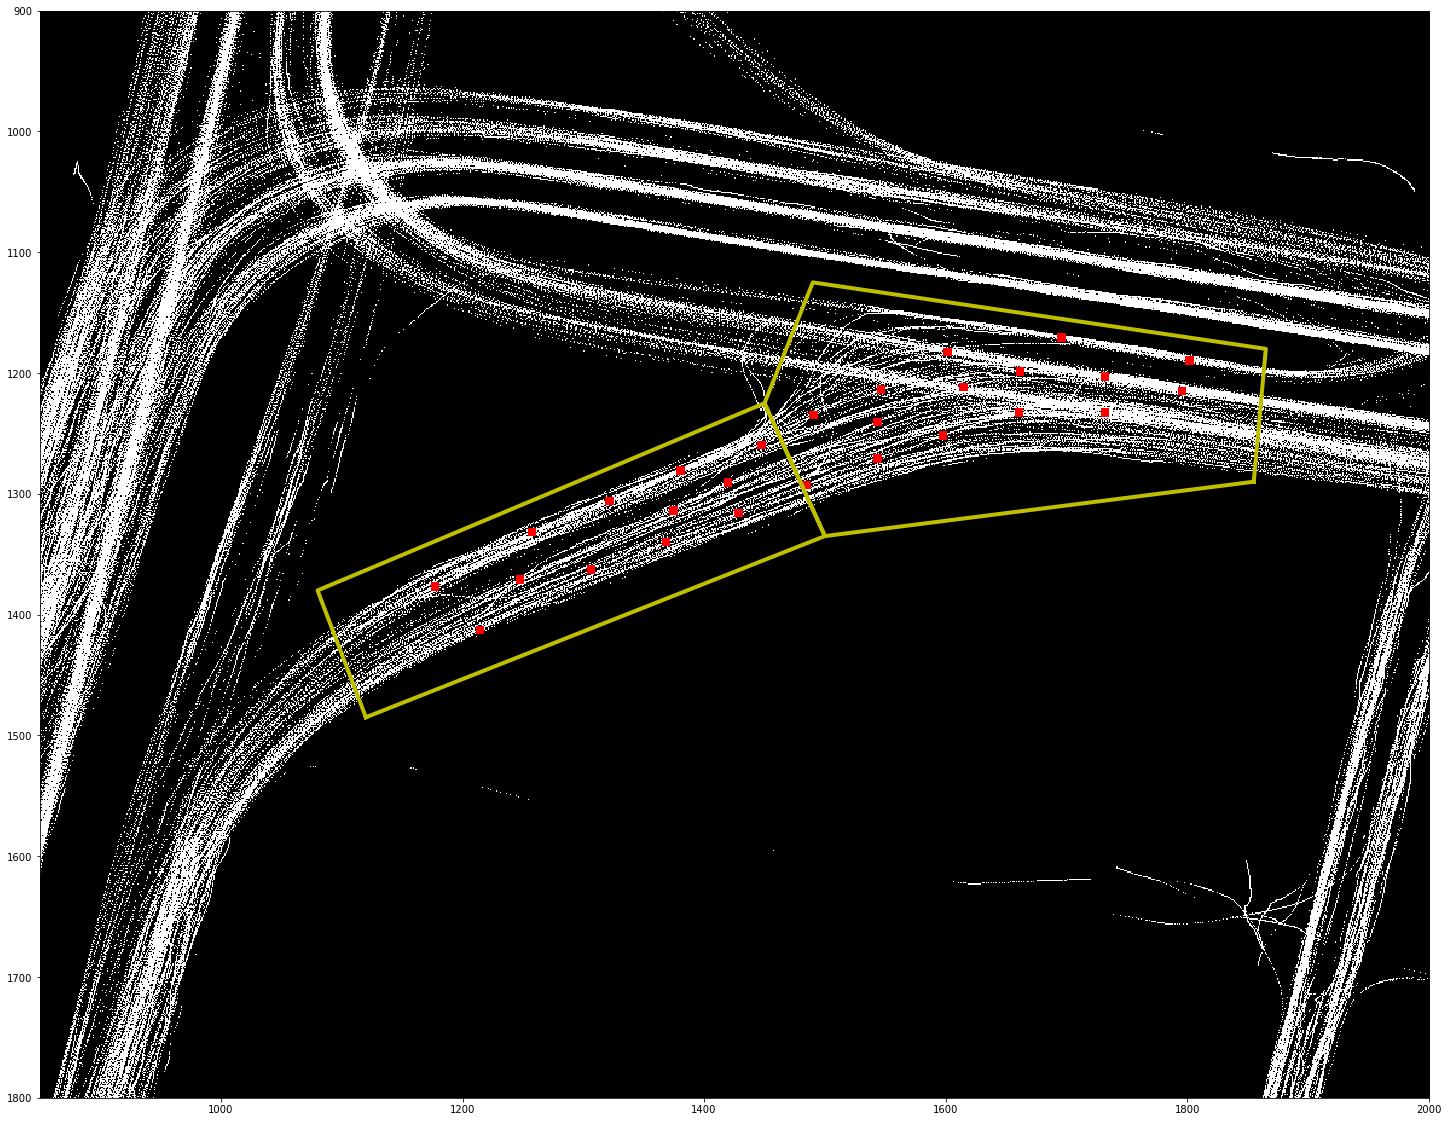

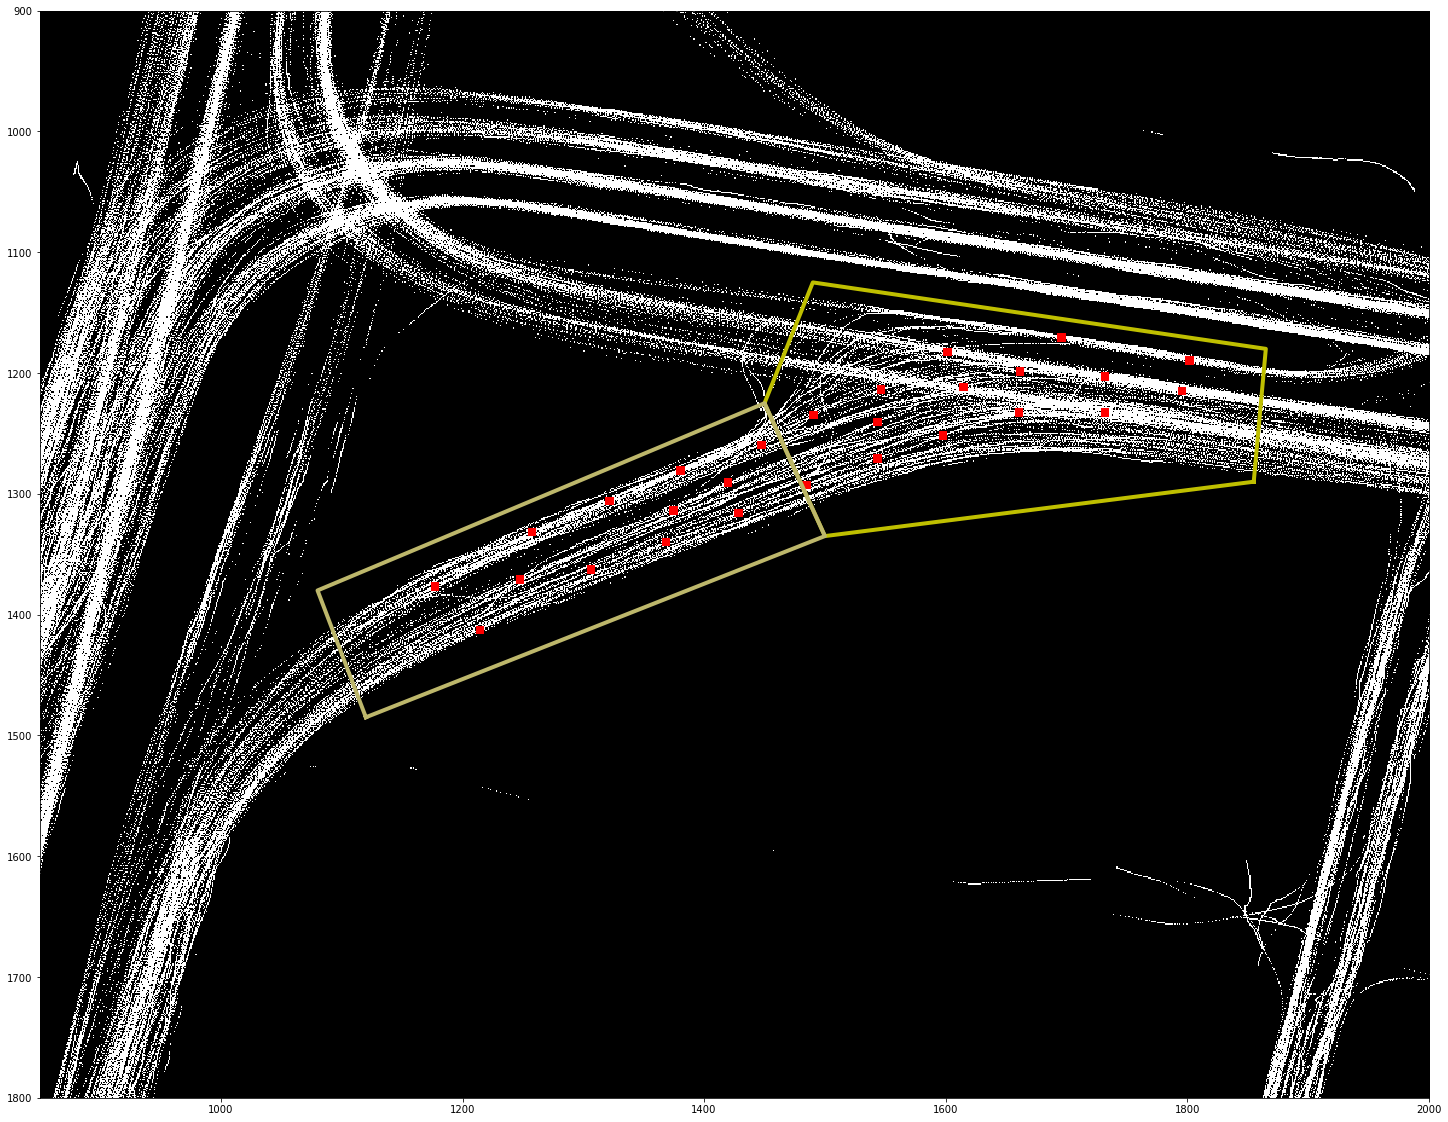

In [120]:
plot_image_with_poly(im_yellowstop, [yellow1_poly, yellow2_poly], (40, 20), 'y', [850,2000,1800,900])

plt.figure(figsize=(40,20))
plt.imshow(im_yellowstop,cmap='gray')
plt.plot(yellow1_poly[:,1],yellow1_poly[:,0],c='y',linewidth=4.0)
plt.plot(yellow2_poly[:,1],yellow2_poly[:,0],c='#BDB76B',linewidth=4.0)
plt.axis([850,2000,1800,900])

We note here that there only seem to be 3 lanes, we'll use this assumption to merge lanes later.

### Yellow1 Stopped Region

In [121]:
yellow1_dist_data = (yellow1_data[['N','E']]-yellow1[0]).dot(yellow1_rotation)
yellow1_dist_data.rename(columns={0:'L',1:'W'}, inplace=True)

In [122]:
yellow1_data = yellow1_data.join(yellow1_dist_data)

In [123]:
yellow1_dist_data_stopped = yellow1_data.xs(frame, level='frame')[['L','W']]
# yellow1_dist_data_stopped.rename(columns={0:'L',1:'W'}, inplace=True)

In [124]:
yellow_width, yellow_kde_est, min_kde = get_kde(yellow1_dist_data_stopped, 5)

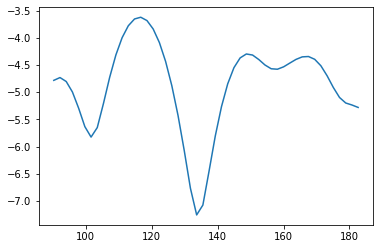

In [125]:
plt.plot(yellow_width,yellow_kde_est)

In [126]:
yellow1_lanes = pd.cut(yellow1_dist_data_stopped['W'],yellow_width[np.concatenate(([0],min_kde,[-1]))],labels=[1,2,3,4,]).rename('Lane')

In [127]:
yellow1_lanes_all = pd.cut(yellow1_dist_data['W'],yellow_width[np.concatenate(([0],min_kde,[-1]))],labels=[1,2,3,4,]).rename('Lane')

In [128]:
yellow1_data_lanes_all = yellow1_data.join(yellow1_lanes_all)

In [129]:
yellow1_data_lanes = yellow1_data.xs(frame, level='frame').join(yellow1_lanes)

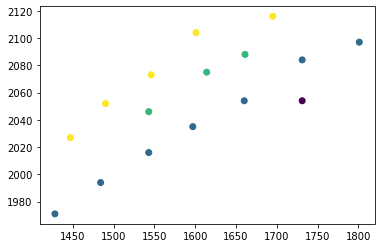

In [130]:
plt.scatter(yellow1_data_lanes['E'],yellow1_data_lanes['N'],c=yellow1_data_lanes.Lane)

We note from the stopped vehicle frame that lane 1 (purple) and lane2 (navy) are basically diverging lanes, so we'll just consider a merged lane of 1 and 2 as the lane of interest for now since it has the longest queue. We will also remap the lanes to be indexed from 1 again.

In [131]:
yellow1_data_lanes['Lane'] = yellow1_data_lanes['Lane'].map({1:2}).fillna(yellow1_data_lanes['Lane'])
yellow1_data_lanes['Lane'] = yellow1_data_lanes['Lane'].map({2:1, 3:2, 4:3}).fillna(yellow1_data_lanes['Lane'])

In [132]:
yellow1_data_lanes_all['Lane'] = yellow1_data_lanes_all['Lane'].map({1:2}).fillna(yellow1_data_lanes_all['Lane'])
yellow1_data_lanes_all['Lane'] = yellow1_data_lanes_all['Lane'].map({2:1, 3:2, 4:3}).fillna(yellow1_data_lanes_all['Lane'])

In [133]:
diff_L_yellow1 = {}
for Lane in range(1,len(min_kde)+2):
    group = yellow1_data_lanes[yellow1_data_lanes['Lane']==Lane]['L']
    lane_L_max = group.max()
    lane_L_min = group.min()
    diff_L_yellow1[str(Lane)] = [lane_L_max - lane_L_min]
    
diff_L_yellow1 = pd.DataFrame.from_dict(diff_L_yellow1)

In [134]:
diff_L_yellow1

,1,2,3,4
0,393.706743,125.235248,263.439497,NaN


we note that lane 1 has the longest queue so far, but we analyze the yellow2 region to confirm.

### Yellow 2 Stopped Region

In [135]:
yellow2_dist_data_stopped = yellow2_data.xs(frame, level='frame')

In [136]:
yellow_width, yellow_kde_est, min_kde = get_kde(yellow2_data, 4.5)

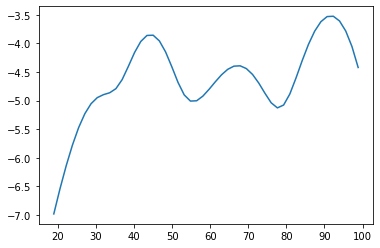

In [137]:
plt.plot(yellow_width,yellow_kde_est)

In [138]:
yellow2_lanes = pd.cut(yellow2_dist_data_stopped['W'],yellow_width[np.concatenate(([0],min_kde,[-1]))],labels=[1,2,3,]).rename('Lane')

In [139]:
yellow2_data_lanes = yellow2_dist_data_stopped.join(yellow2_lanes)

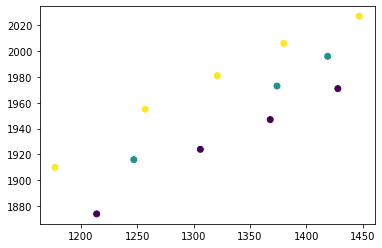

In [140]:
plt.scatter(yellow2_dist_data_stopped['E'],yellow2_dist_data_stopped['N'],c=yellow2_lanes)

In [141]:
diff_L_yellow2 = {}
for Lane in range(1,len(min_kde)+2):
    group = yellow2_data_lanes[yellow2_data_lanes['Lane']==Lane]['L']
    lane_L_max = group.max()
    lane_L_min = group.min()
    diff_L_yellow2[str(Lane)] = [lane_L_max - lane_L_min]
    
diff_L_yellow2 = pd.DataFrame.from_dict(diff_L_yellow2)

In [142]:
diff_L_yellow2

,1,2,3
0,234.668371,189.360021,294.100394


We note that Lane 1 and 3 have the longest queue lengths. We add the lengths of region 1 and 2 to get a total length. 

In [143]:
total_diff_L_yellow = {str(Lane): diff_L_yellow1[str(Lane)] + diff_L_yellow2[str(Lane)] for Lane in range(1,4)}
total_diff_L_yellow = pd.DataFrame.from_dict(total_diff_L_yellow)

In [144]:
total_diff_L_yellow

,1,2,3
0,628.375114,314.595269,557.539892


We now see that Lane 1 has the longest queue, and we compute the length for it

### Yellow Results

#### Yellow 1

In [145]:
queue_lane_data1 = yellow1_data_lanes[yellow1_data_lanes['Lane']==1]
queue_lane_data1 = queue_lane_data1.sort_values('L')
queue_lane_data1['N']

track_id
1322    2097
1392    2084
1409    2054
1302    2054
1313    2035
1321    2016
1326    1994
1401    1971
Name: N, dtype: int64

In [146]:
veh_first = 1322
veh_last = 1401
lane=1
dists, piecewise_dist1, coordinates1, timestamp1 = get_results(veh_first, veh_last, frame, lane, queue_lane_data1,  yellow1_data, )

Straight line length (in m):  35.62607007258886
Piecewise length (in m): 38.26840019539686
Lane:  1
Coordinates (lat,lon):  ((37.99162, 23.732079), (37.991494, 23.731706))
Timestamp (s): 509.12


#### Yellow 2

In [147]:
queue_lane_data2 = yellow2_data_lanes[yellow2_data_lanes['Lane']==1]
queue_lane_data2 = queue_lane_data2.sort_values('L')
queue_lane_data2['N']

track_id
1401    1971
1410    1947
1488    1924
1383    1874
Name: N, dtype: int64

In [148]:
veh_first = 1401
veh_last = 1383
lane=1
dists, piecewise_dist2, coordinates2, timestamp2 = get_results(veh_first, veh_last, frame, lane, queue_lane_data2,  yellow2_data, )

Straight line length (in m):  21.66370619193145
Piecewise length (in m): 21.724490833716672
Lane:  1
Coordinates (lat,lon):  ((37.991494, 23.731706), (37.991397, 23.731492))
Timestamp (s): 509.12


#### Spillback Into Yellow2

We classify a spillback as the first time a queue forms in the yellow2 region in lane 1 and there are no moving vehicles in the yellow1 region lane 1.

In [149]:
yellow1_data_stopped = yellow1_data[yellow1_data['speed']<threshold]
num_stopped_cars = len(yellow1_data.xs(frame, level='frame')[['N','E']])
congested_frames = yellow1_data_stopped.groupby('frame').size()[yellow1_data_stopped.groupby('frame').size() >= num_stopped_cars]

We check how many cars are in Lane 1 in maximum queue length, assuming that the 

In [150]:
yellow1_data_lanes.groupby('Lane').size()

Lane
1    8
2    3
3    5
4    0
dtype: int64

We select all frames where lane 1 has minimum 8 cars in it:

In [151]:
groupby_lane1_frames = yellow1_data_lanes_all[yellow1_data_lanes_all['Lane'] == 1].groupby('frame')
congested_lane_frames = groupby_lane1_frames.size()[groupby_lane1_frames.size()>=8].index
congested_lane_frames = np.array(congested_lane_frames)

We find the frames prior to our maximum queue length frame:

In [152]:
congested_lane_frames = congested_lane_frames[congested_lane_frames <= frame]

Let's find continuous sequences of frames where 8 cars are in Lane 1 of region yellow1

In [153]:
discontinuities = np.where(np.diff(congested_lane_frames) != 1)[0]

In [154]:
possible_spillback_frames = congested_lane_frames[discontinuities[-1]+1:]

Find the first spillback frame in yellow2 with a stopped vehicle:

In [155]:
yellow2_data_stopped = yellow2_data[yellow2_data['speed']<threshold]

In [156]:
stopped_frames2 = set(list(yellow2_data_stopped.groupby('frame').groups.keys()))

In [157]:
spillback_frame = list(set.intersection(stopped_frames2, set(possible_spillback_frames)))[0]
print('Spillback Frame: ', spillback_frame)

Spillback Frame:  12578


In [158]:
spillback_time = yellow2_data_stopped.xs(spillback_frame, level='frame').iloc[0]['time']

#### Aggregated Results

In [159]:
total_length = piecewise_dist1 + piecewise_dist2
lane = 1
coordinates = (coordinates1[0], coordinates2[-1])

print('Piecewise length (in m):', 1e3*total_length)
print('Lane: ', 1)
print('Coordinates (lat,lon): ', coordinates)
print('Timestamp (s):', queue_lane_data1.loc[veh_first]['time'])
print('Spillback (s):', spillback_time)

Piecewise length (in m): 59.99289102911353
Lane:  1
Coordinates (lat,lon):  ((37.99162, 23.732079), (37.991397, 23.731492))
Timestamp (s): 509.12
Spillback (s): 503.12


In [160]:
add_result('Yellow', total_length, lane, coordinates, queue_lane_data1.loc[veh_first]['time'], spillback_time)

## Results

In [161]:
results_df = pd.DataFrame.from_dict(results)

In [162]:
results_df

,Region,Queue Length,Lane,Initial Coords.,Final Coords.,Time (s),Spillback Time (s)
0,Green,44.951925,4,"(37.991977, 23.731341)","(37.9923, 23.731417)",307.88,NaN
1,Red,100.074740,3,"(37.991631, 23.732428)","(37.991457, 23.733544)",790.88,NaN
2,Yellow,59.992891,1,"(37.99162, 23.732079)","(37.991397, 23.731492)",509.12,503.12


In [163]:
results_df.to_csv('Results.csv', index=None)

In [164]:
end_time = time.time()

In [165]:
print('Runtime: {:.2f}s'.format(end_time - start_time))

Runtime: 311.75s
